## LSTM Predictions on Closing Stock Price and Stock Returns for AAPL Stock

This notebook contains the LSTM done by our group.

1. Predicting Closing Stock Price for AAPL using Closing Price and Volume
2. Predicting Stock Returns for AAPL using Returns, Closing Price, and Volume

In [124]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
            
from datetime import date

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error



### Plotting Stocks

In [125]:
def scrapeStock(ticker_sym):
    # Input ticker - Using META as example
    ticker_data = yf.Ticker(ticker_sym)

    # Getting historical data of META
    ticker_historical = ticker_data.history(period='3y')
    ticker_historical.index = pd.to_datetime(ticker_historical.index, utc=True).date

    # Plotting Closing Price
    fig, (ax1, ax2) = plt.subplots(2,1)
    plt.figure(figsize=(16,16))
    ax1.plot(ticker_historical.index, ticker_historical["Close"], label='Close Price History')
    ax1.set_title('{} Historical Close Price (3 Year Period)'.format(ticker_sym))

    # Plotting Volume Traded 
    # ax2.figure(figsize=(16,8))
    ax2.plot(ticker_historical.index, ticker_historical["Volume"], label='Volume Traded History')
    ax2.set_title('{} Historical Volume Traded (3 Year Period)'.format(ticker_sym))

    plt.show()

    return ticker_historical


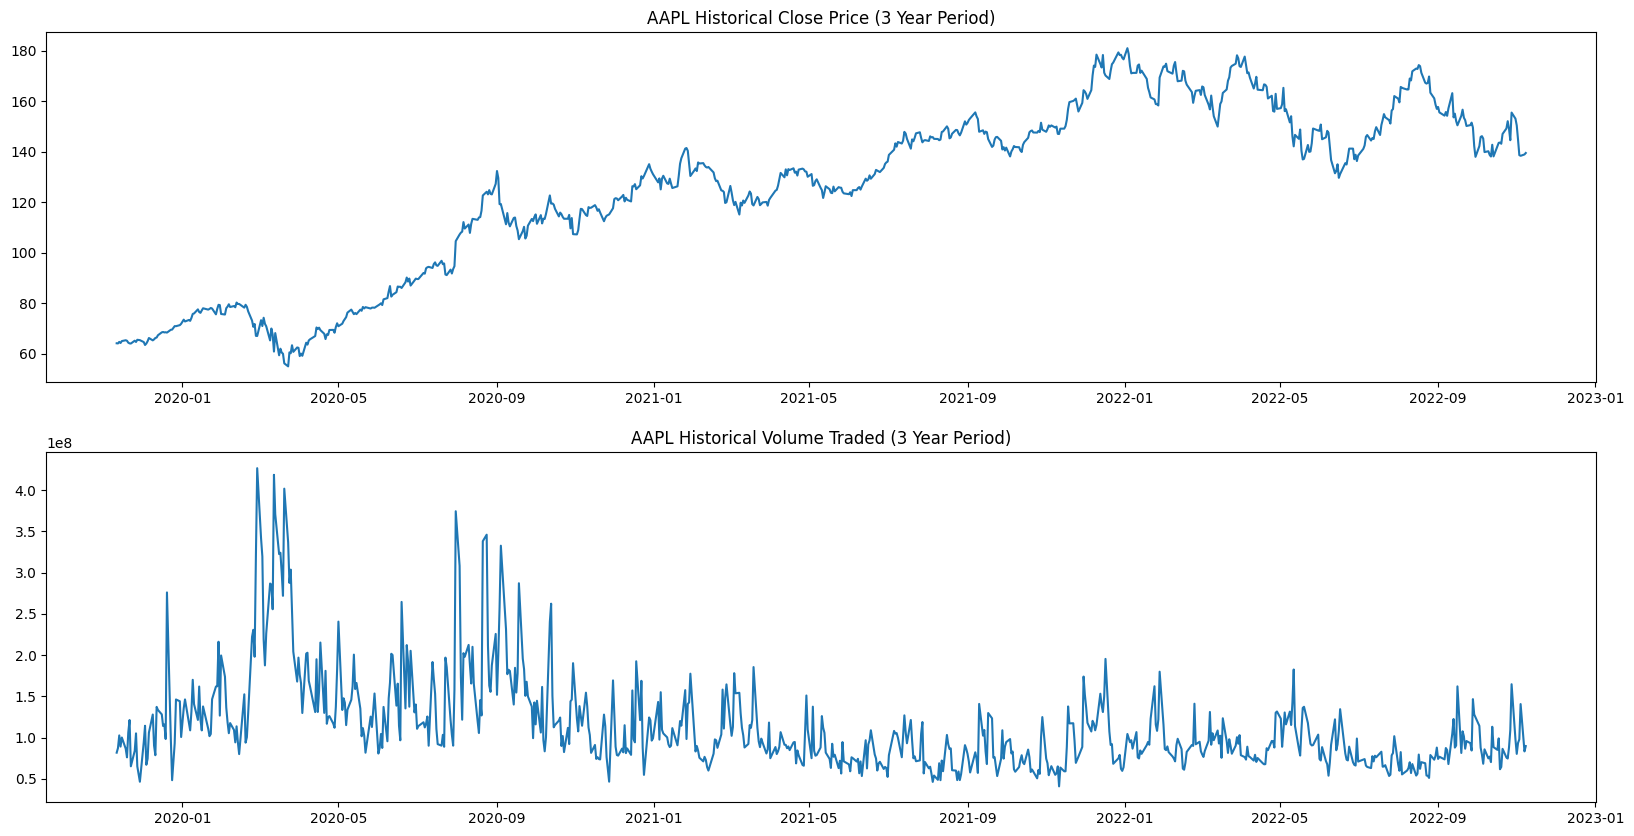

<Figure size 1600x1600 with 0 Axes>

In [126]:
aapl_historical = scrapeStock("AAPL")

### Predicting Close Price using Closing Price and Volume Traded
We are able to predict the closing price, we will provide valuable information to investors as they will know whether to long or short the stock.


In [127]:
def predictClosing(ticker_historical, ticker_sym, num_features, features):
    # Normalizing
    ticker_historical_close = ticker_historical[features]

    # Spliting into Train and Test Data
    train_test_split = int(len(ticker_historical_close) * 0.8)
    ticker_historical_x_train = ticker_historical_close.iloc[:train_test_split]


    # Scaling based on Training Data
    scaler_price = MinMaxScaler(feature_range=(0,1))
    scaled_price_data = scaler_price.fit_transform(ticker_historical_x_train) # scale only after split

    x_train_data, y_train_data = [], []
    num_input_points = 60

    # Creating Training Data
    for i in range(num_input_points, train_test_split):
        x_train_data.append(scaled_price_data[i-num_input_points:i])
        y_train_data.append(scaled_price_data[i, 0])

    x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
    x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], num_features)) # shape is ((2019, 60), 1)

    # Building the LSTM Model
    lstm_model_price = Sequential()
    lstm_model_price.add(LSTM(units=100, return_sequences=True, input_shape=(x_train_data.shape[1], num_features)))
    lstm_model_price.add(LSTM(units=100))
    lstm_model_price.add(Dense(25))
    lstm_model_price.add(Dense(1)) 
    lstm_model_price.compile(loss='mean_squared_error',optimizer='adam', metrics=['mean_squared_error'])
    lstm_model_price.fit(x_train_data,y_train_data,epochs=30,batch_size=1,verbose=1)

    # Preparing Test data
    test_input = ticker_historical_close.iloc[train_test_split - num_input_points:]
    test_input = scaler_price.transform(test_input) 

    X_test = []
    # Creating Test Data
    for i in range(num_input_points, test_input.shape[0]):
        X_test.append(test_input[i - num_input_points:i])
    X_test = np.array(X_test)

    predicted_closing_price = lstm_model_price.predict(X_test)
    temp_column = np.zeros((predicted_closing_price.shape[0],num_features-1), dtype=int)
    inverse_input = np.append(predicted_closing_price, temp_column, axis=1)

    predicted_closing_price = scaler_price.inverse_transform(inverse_input)[:,0]

    # Visualize the predicted stock costs with actual stock cost
    train_data_price = ticker_historical_close[:train_test_split]
    test_data_price = ticker_historical_close[train_test_split:]
    test_data_price['Predictions'] = predicted_closing_price
    plt.title('{} Close Price Predictions using LSTM Model'.format(ticker_sym))
    plt.plot(train_data_price['Close'])
    plt.plot(test_data_price['Close'])
    plt.plot(test_data_price['Predictions'])
    plt.legend(['Train Data', 'Test Data', 'Prediction'])

    # plt.legend()
    plt.show()

    print("R-Squared Score: ", r2_score(test_data_price['Close'], test_data_price['Predictions']))
    print("Mean Squared Error: ", mean_squared_error(test_data_price['Close'], test_data_price['Predictions']))
    print("Mean Absolute Error: ", mean_absolute_error(test_data_price['Close'], test_data_price['Predictions']))


    return lstm_model_price

Epoch 1/30


2022-11-09 12:55:13.127566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 12:55:13.353494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 12:55:13.552208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 12:55:13.732896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 12:55:14.029614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


544/544 [==============================] - 21s 35ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 2/30
544/544 [==============================] - 19s 35ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 3/30
544/544 [==============================] - 19s 35ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 4/30
544/544 [==============================] - 18s 34ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 5/30
544/544 [==============================] - 18s 34ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 6/30
544/544 [==============================] - 18s 33ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 7/30
544/544 [==============================] - 19s 35ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 8/30
544/544 [==============================] - 18s 32ms/step - loss: 8.4193e-04 - mean_squared_error: 8.4193e-04
Epoch 9/30
544/544 [==============================] - 17s 32ms/step - loss: 8.2277e-04 - mean_squared_error

2022-11-09 13:04:07.989329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 13:04:08.074178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/5 [=================>............] - ETA: 0s

2022-11-09 13:04:08.227141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 56ms/step


/var/folders/kz/rvchp60d4w32sw9xqslynkzm0000gn/T/ipykernel_25572/2514717703.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_price['Predictions'] = predicted_closing_price


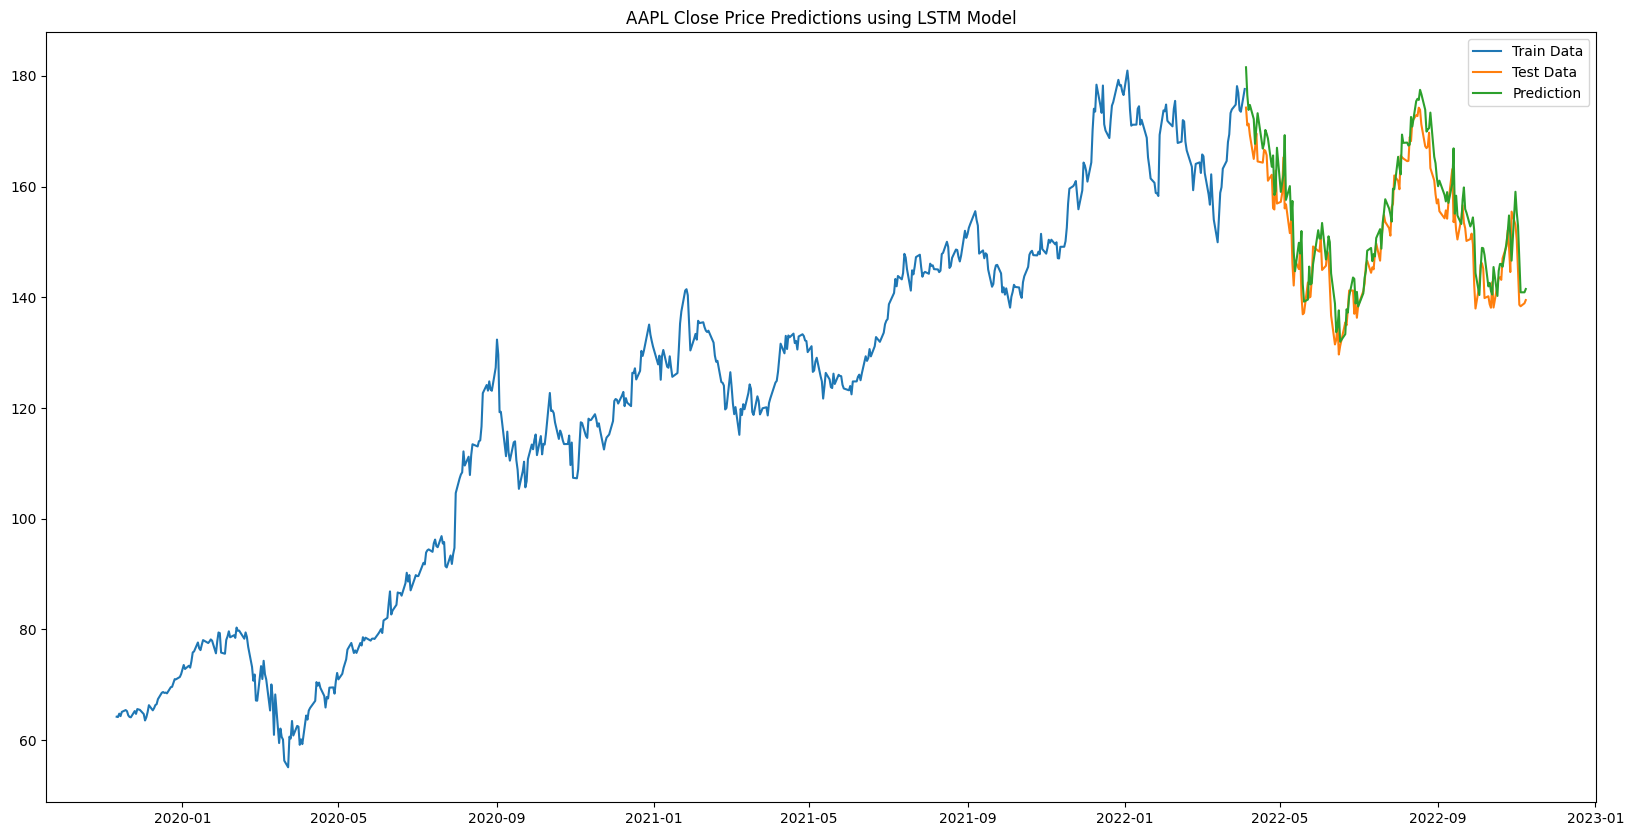

R-Squared Score:  0.8177669422202214
Mean Squared Error:  22.13451286321519
Mean Absolute Error:  3.72304757515461


In [128]:
aapl_lstm_model_price = predictClosing(aapl_historical, 'AAPL', 2, ['Close', 'Volume'])

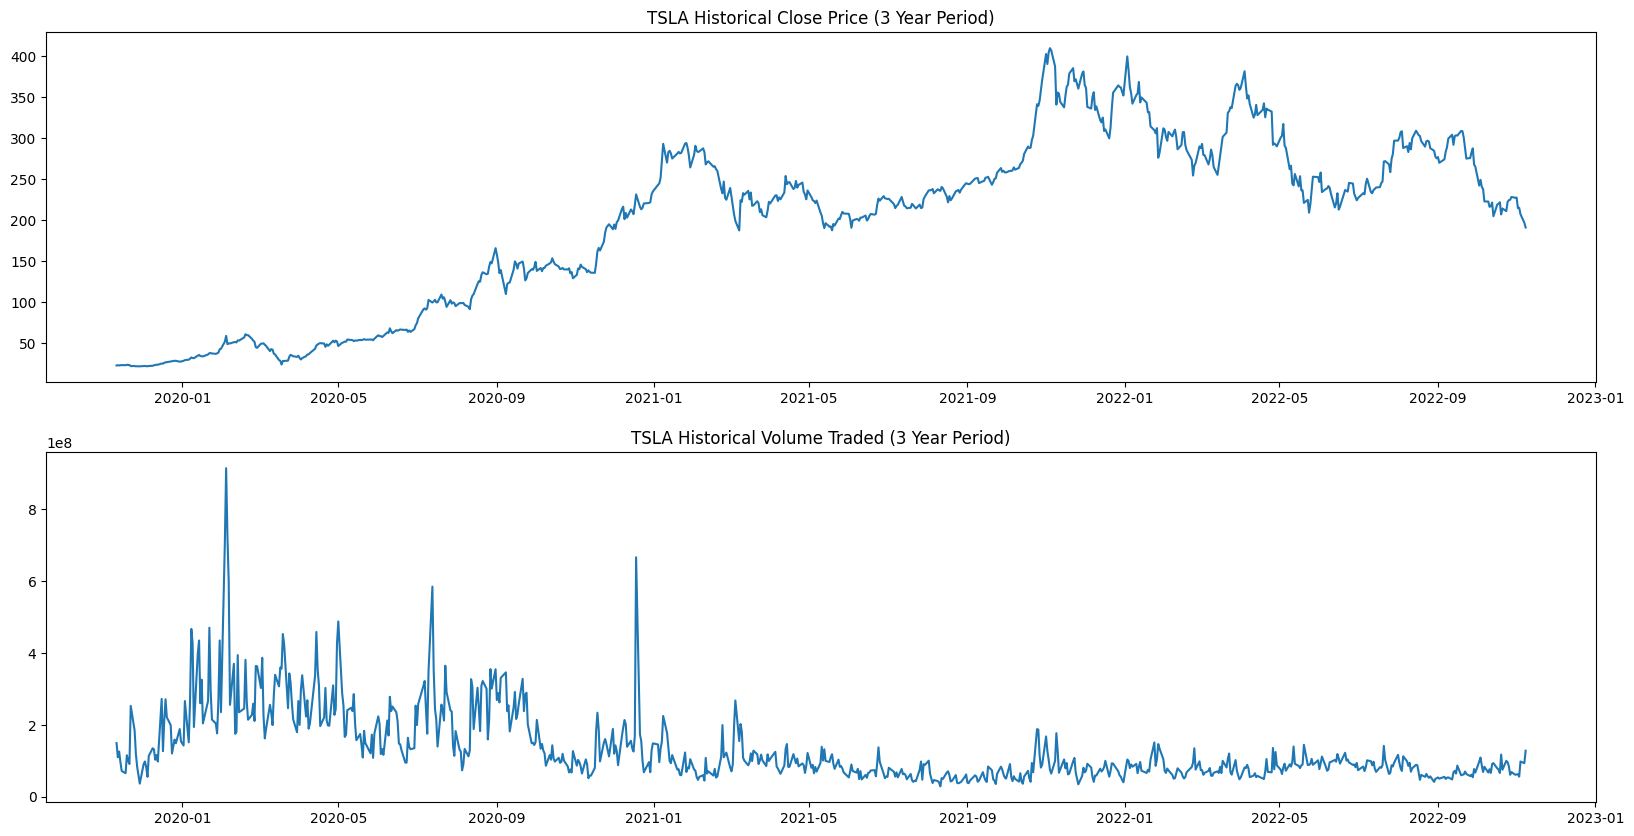

<Figure size 1600x1600 with 0 Axes>

In [129]:
tsla_historical = scrapeStock("TSLA")


Epoch 1/30


2022-11-09 13:04:10.583763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 13:04:10.790718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 13:04:10.900096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 13:04:11.038324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 13:04:11.253692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


544/544 [==============================] - 19s 32ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 2/30
544/544 [==============================] - 18s 32ms/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 3/30
544/544 [==============================] - 18s 33ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 4/30
544/544 [==============================] - 18s 32ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 5/30
544/544 [==============================] - 19s 34ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 6/30
544/544 [==============================] - 18s 32ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 7/30
544/544 [==============================] - 17s 32ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 8/30
544/544 [==============================] - 17s 32ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 9/30
544/544 [==============================] - 17s 32ms/step - loss: 9.1720e-04 - mean_squared_error: 9.1720

2022-11-09 13:12:45.010357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 13:12:45.117653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 7s

2022-11-09 13:12:45.257412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 64ms/step


/var/folders/kz/rvchp60d4w32sw9xqslynkzm0000gn/T/ipykernel_25572/2514717703.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_price['Predictions'] = predicted_closing_price


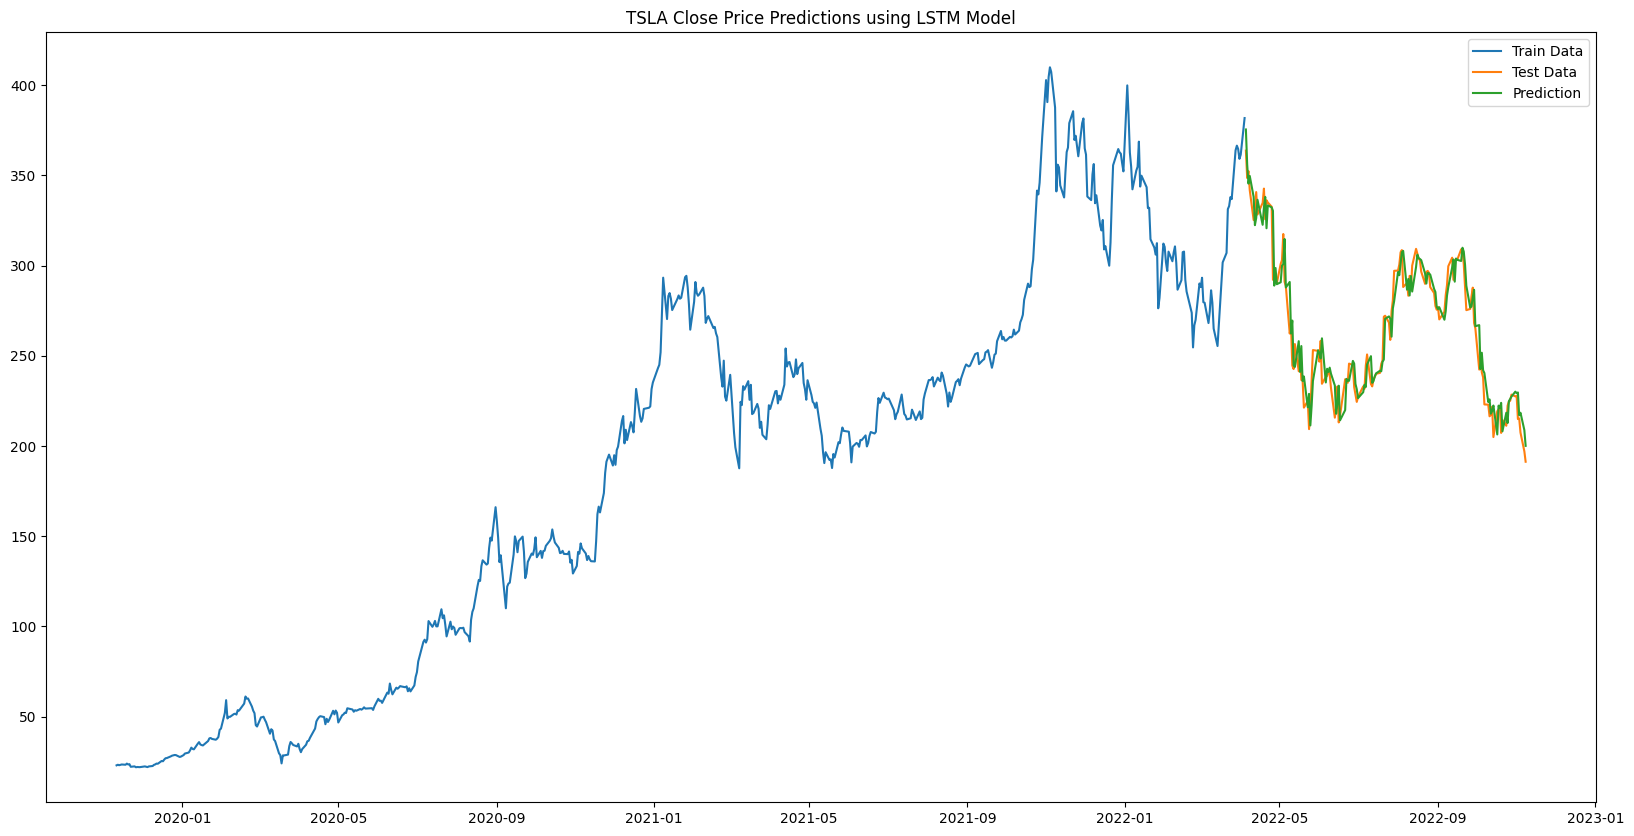

R-Squared Score:  0.9260957582432984
Mean Squared Error:  112.4413779280902
Mean Absolute Error:  7.956641144078033


In [130]:
tsla_lstm_model_price = predictClosing(tsla_historical, 'TSLA', 2, ['Close', 'Volume'])

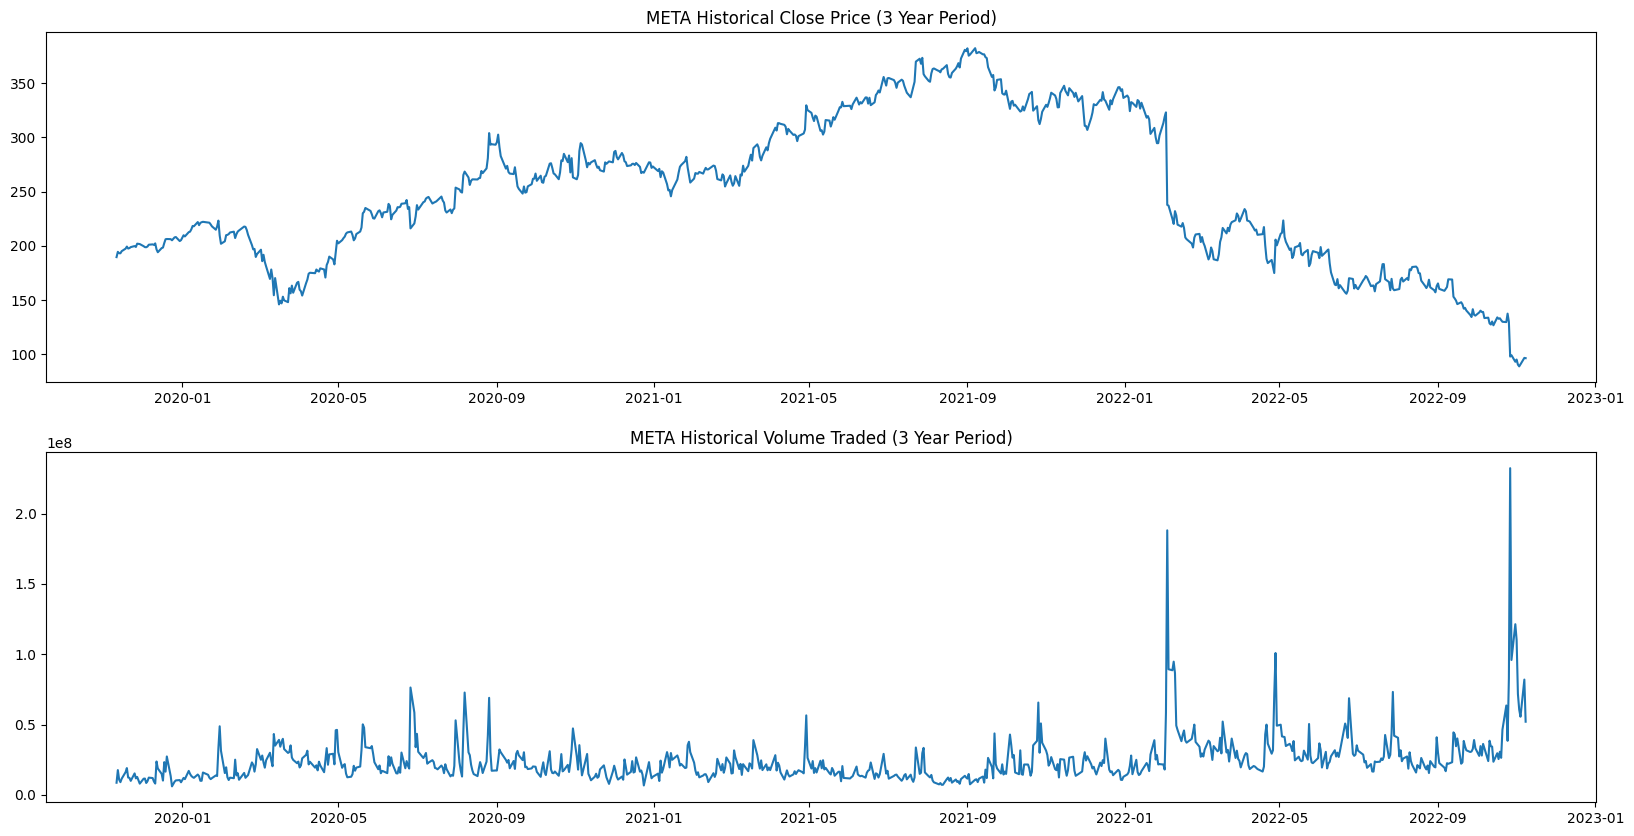

<Figure size 1600x1600 with 0 Axes>

In [131]:
meta_historical = scrapeStock("META")

Epoch 1/30


2022-11-09 13:12:47.636750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 13:12:47.836775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 13:12:47.956026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 13:12:48.103588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 13:12:48.301527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


544/544 [==============================] - 20s 33ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 2/30
544/544 [==============================] - 18s 32ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 3/30
544/544 [==============================] - 17s 32ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 4/30
544/544 [==============================] - 17s 31ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 5/30
544/544 [==============================] - 17s 31ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 6/30
544/544 [==============================] - 17s 31ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 7/30
544/544 [==============================] - 17s 31ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 8/30
544/544 [==============================] - 17s 31ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 9/30
544/544 [==============================] - 17s 31ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epo

2022-11-09 13:46:25.774122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 13:46:25.881683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 4s

2022-11-09 13:46:26.178470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 68ms/step


/var/folders/kz/rvchp60d4w32sw9xqslynkzm0000gn/T/ipykernel_25572/2514717703.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_price['Predictions'] = predicted_closing_price


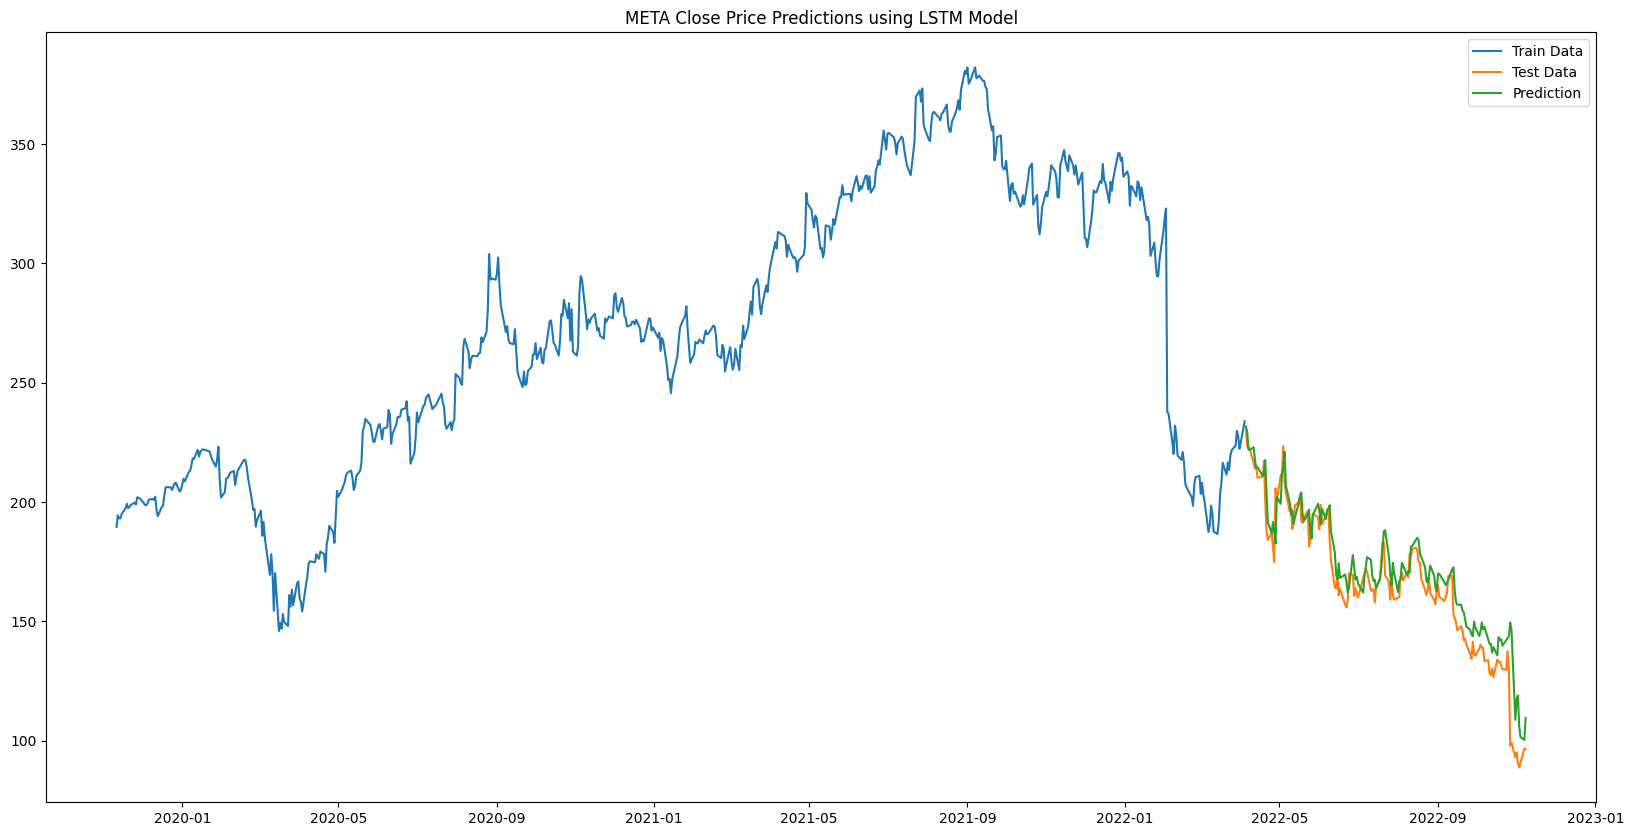

R-Squared Score:  0.876298575720254
Mean Squared Error:  113.52934962010197
Mean Absolute Error:  7.893609284579116


In [132]:
meta_lstm_model_price = predictClosing(meta_historical, 'META', 2, ['Close', 'Volume'])

#### Including Sentiment Analysis

In [90]:
def includeSentiment(ticker_historical, ticker_sym, sentiment_filepath='../Data/3_Predictions/Unstructured_Data/rf_regressor/close', sentiment_file='/finbert_pred_close_rfr_test.csv'):
    # sentiment data
    Xhist_sent = pd.read_csv(sentiment_filepath + sentiment_file, index_col=0)[ticker_sym]
    Xhist_sent.index = pd.to_datetime(Xhist_sent.index, utc=True).date
    Xhist_sent.index.rename('Date', inplace=True)

    ticker_historical = ticker_historical.merge(Xhist_sent, how='inner', left_index=True, right_index=True).rename(columns={ticker_sym: 'Sentiment'})

    return ticker_historical

Epoch 1/30


2022-11-08 23:44:57.193146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-08 23:44:57.451665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-08 23:44:57.563141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-08 23:44:57.693716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/77 [..............................] - ETA: 2:22 - loss: 0.4497 - mean_squared_error: 0.4497

2022-11-08 23:44:57.897865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


77/77 [==============================] - 4s 33ms/step - loss: 0.0429 - mean_squared_error: 0.0429
Epoch 2/30
77/77 [==============================] - 2s 32ms/step - loss: 0.0241 - mean_squared_error: 0.0241
Epoch 3/30
77/77 [==============================] - 3s 33ms/step - loss: 0.0153 - mean_squared_error: 0.0153
Epoch 4/30
77/77 [==============================] - 3s 33ms/step - loss: 0.0149 - mean_squared_error: 0.0149
Epoch 5/30
77/77 [==============================] - 2s 32ms/step - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 6/30
77/77 [==============================] - 2s 32ms/step - loss: 0.0123 - mean_squared_error: 0.0123
Epoch 7/30
77/77 [==============================] - 2s 32ms/step - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 8/30
77/77 [==============================] - 2s 32ms/step - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 9/30
77/77 [==============================] - 3s 33ms/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 10/30
77/77 [===========

2022-11-08 23:46:14.444815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-08 23:46:14.520632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-08 23:46:14.641882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 150ms/step


/var/folders/kz/rvchp60d4w32sw9xqslynkzm0000gn/T/ipykernel_25572/1007799305.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_price['Predictions'] = predicted_closing_price


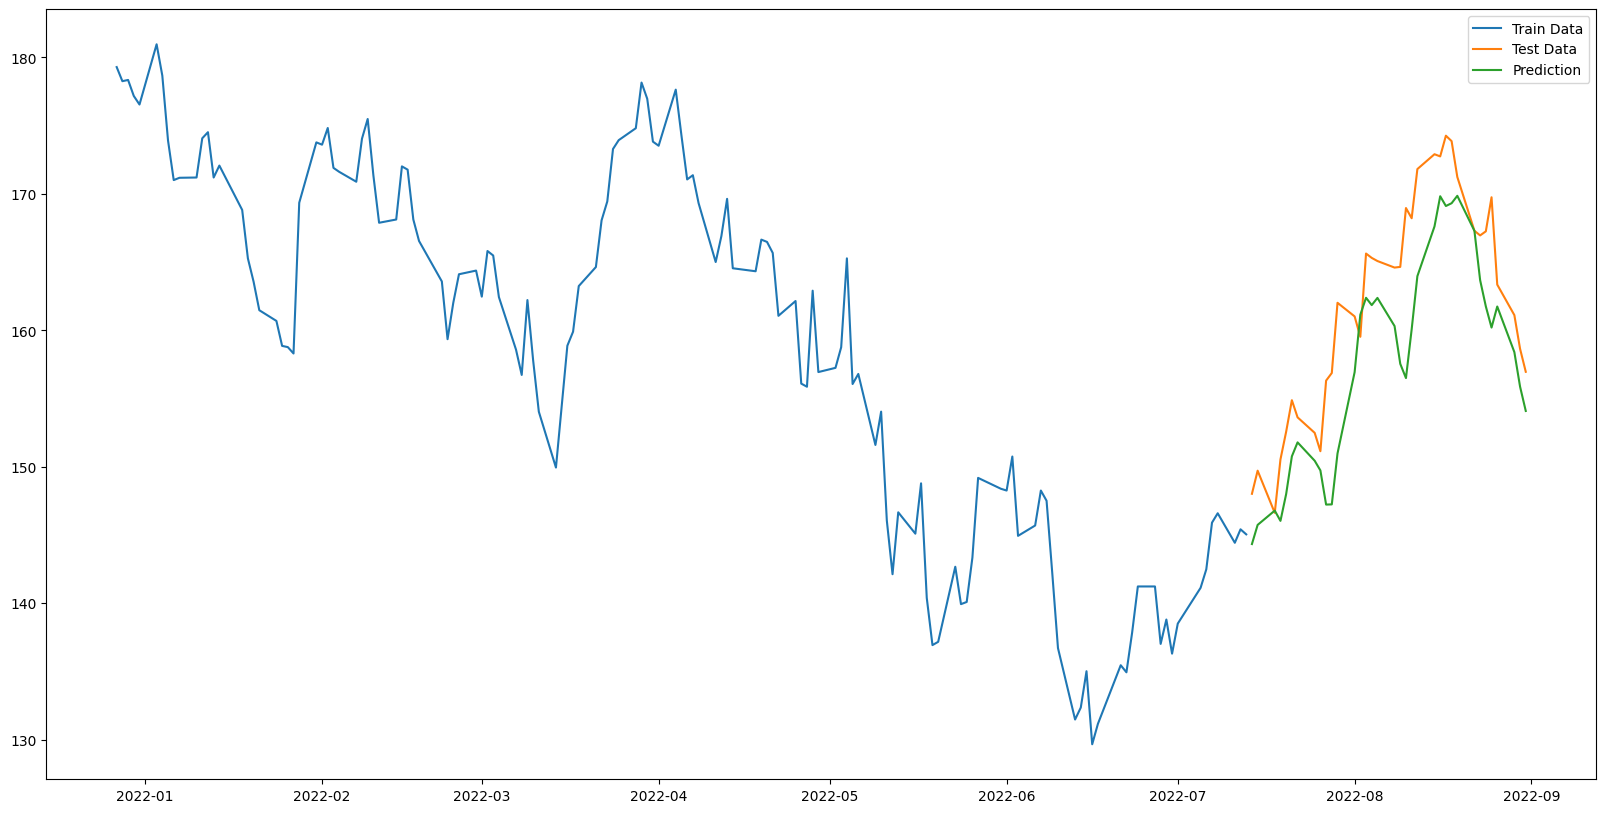

R-Squared Score:  0.5317627339544023
Mean Squared Error:  29.678520288289832
Mean Absolute Error:  4.530595388939166


In [97]:
aapl_historical_w_sent = includeSentiment(aapl_historical, 'AAPL')
aapl_lstm_model_sent_price = predictClosing(aapl_historical_w_sent, 3, ['Close', 'Volume', 'Sentiment'])

Epoch 1/30


2022-11-08 23:54:27.918934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-08 23:54:28.127437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-08 23:54:28.254704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-08 23:54:28.378529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/77 [..............................] - ETA: 3:08 - loss: 1.1037e-04 - mean_squared_error: 1.1037e-04

2022-11-08 23:54:28.579947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


77/77 [==============================] - 5s 33ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 2/30
77/77 [==============================] - 2s 32ms/step - loss: 0.0146 - mean_squared_error: 0.0146
Epoch 3/30
77/77 [==============================] - 3s 33ms/step - loss: 0.0126 - mean_squared_error: 0.0126
Epoch 4/30
77/77 [==============================] - 2s 32ms/step - loss: 0.0113 - mean_squared_error: 0.0113
Epoch 5/30
77/77 [==============================] - 2s 32ms/step - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 6/30
77/77 [==============================] - 3s 34ms/step - loss: 0.0146 - mean_squared_error: 0.0146
Epoch 7/30
77/77 [==============================] - 2s 32ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 8/30
77/77 [==============================] - 2s 32ms/step - loss: 0.0113 - mean_squared_error: 0.0113
Epoch 9/30
77/77 [==============================] - 3s 34ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 10/30
77/77 [===========

2022-11-08 23:55:45.858411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-08 23:55:45.935677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-08 23:55:46.038423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 178ms/step


/var/folders/kz/rvchp60d4w32sw9xqslynkzm0000gn/T/ipykernel_25572/1007799305.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_price['Predictions'] = predicted_closing_price


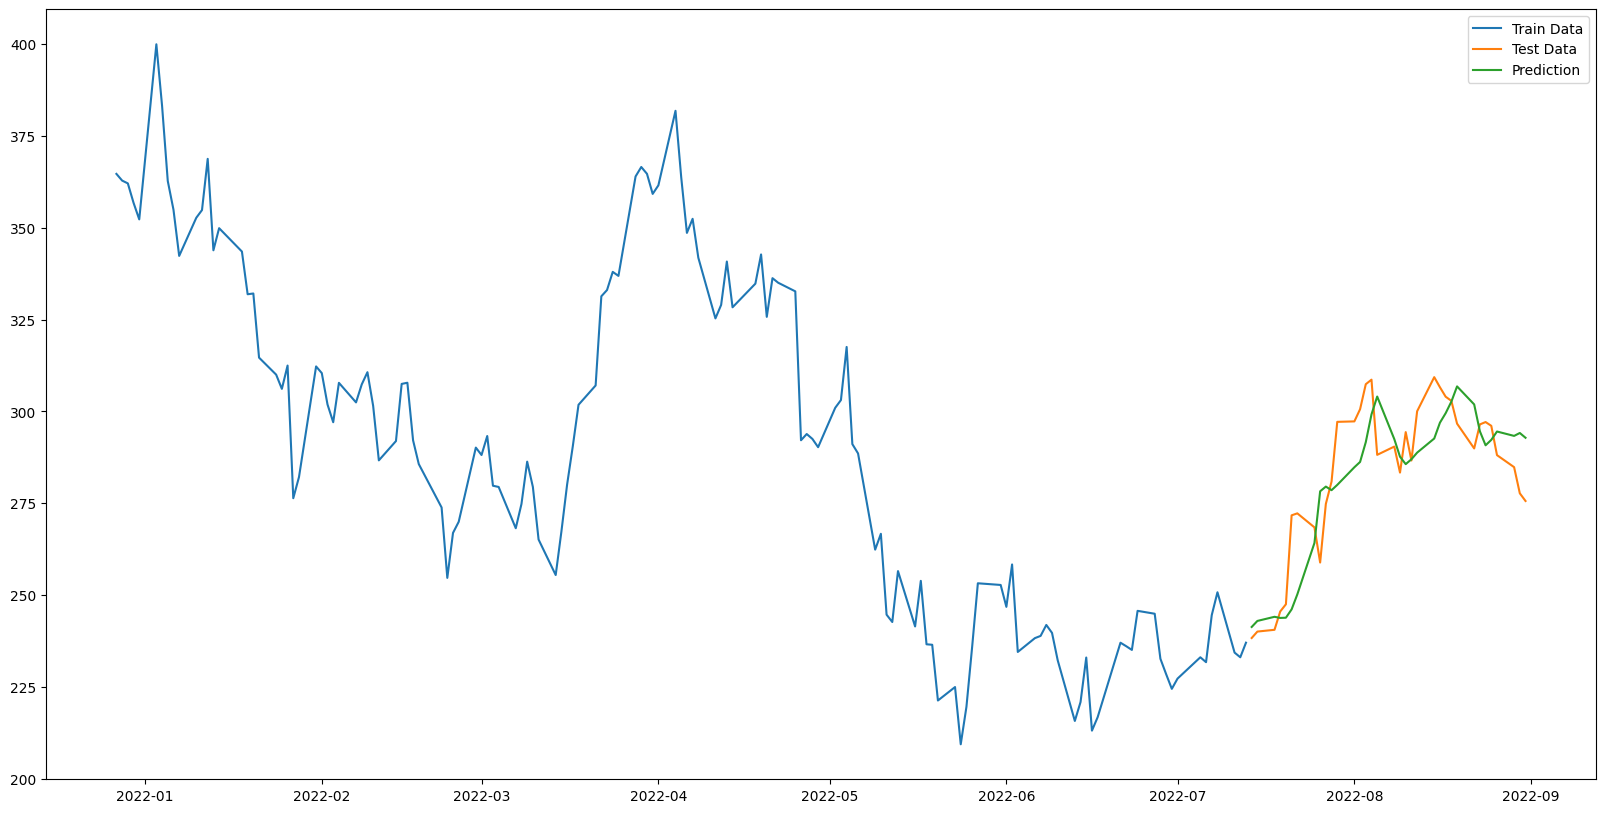

R-Squared Score:  0.7002800255789818
Mean Squared Error:  127.35284426550443
Mean Absolute Error:  9.105446266595703


In [108]:
tsla_historical_w_sent = includeSentiment(tsla_historical, 'TSLA')
# tsla_historical_w_sent[['Close', 'Sentiment']].head(50)
tsla_lstm_model_sent_price = predictClosing(tsla_historical_w_sent, 3, ['Close', 'Volume', 'Sentiment'])

### Predicting Stock Returns using Closing Price and Volume Traded

We are able to predict the stock returns for the next day, we will provide valuable information to investors as they will know whether to long or short the stock.



In [133]:
def getReturns(closingPrices):
  return pd.concat([pd.Series(np.nan), closingPrices.diff().reset_index(drop=True)[1:].reset_index(drop=True).div(closingPrices[:-1].reset_index(drop=True))]).reset_index(drop=True)

def generateReturnsData(ticker_historical, ticker_sym):

  ticker_historical_returns = getReturns(ticker_historical['Close'])
  ticker_historical_returns.index = ticker_historical.index
  ticker_historical['Returns'] = ticker_historical_returns
  ticker_historical = ticker_historical[1:]

  plt.figure(figsize=(16,8))
  plt.plot(ticker_historical.index, ticker_historical["Returns"], label='{} Stock Returns 3 Year'.format(ticker_sym))
  plt.title('{} Stock Returns (3 Year Period)'.format(ticker_sym))
  plt.show()

  return ticker_historical

def predictReturns(ticker_historical, num_features, features):

  ticker_historical_returns = ticker_historical[features]

  # Spliting into Train and Test Data
  train_test_split = int(len(ticker_historical_returns) * 0.8)
  ticker_historical_train = ticker_historical_returns.iloc[:train_test_split]

  # Scaling based on Training Data
  scaler_returns = MinMaxScaler(feature_range=(0,1))
  scaled_returns_data = scaler_returns.fit_transform(ticker_historical_train) # scale only after split

  x_train_data, y_train_data = [], []
  num_input_points = 60

  # Creating Training Data
  for i in range(num_input_points, train_test_split):
      x_train_data.append(scaled_returns_data[i-num_input_points:i])
      y_train_data.append(scaled_returns_data[i, 0])

  x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
  x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], num_features)) 

  # Continuous
  # Building the LSTM Model
  lstm_model_returns = Sequential()
  lstm_model_returns.add(LSTM(units=100, return_sequences=True, input_shape=(x_train_data.shape[1], num_features)))
  lstm_model_returns.add(LSTM(units=100))
  lstm_model_returns.add(Dense(25))
  lstm_model_returns.add(Dense(1))
  lstm_model_returns.compile(loss='mean_squared_error',optimizer='adam', metrics=['mean_squared_error'])
  lstm_model_returns.fit(x_train_data,y_train_data,epochs=30,batch_size=1,verbose=1)

  # Preparing Test data
  test_input = ticker_historical_returns[train_test_split - num_input_points:]
  test_input = scaler_returns.transform(test_input)

  X_test = []
  for i in range(num_input_points, test_input.shape[0]):
      X_test.append(test_input[i - num_input_points:i])
  X_test = np.array(X_test)

  predicted_closing_returns = lstm_model_returns.predict(X_test)
  temp_column = np.zeros((predicted_closing_returns.shape[0],num_features-1), dtype=int)
  inverse_input = np.append(predicted_closing_returns, temp_column, axis=1)
  predicted_closing_returns = scaler_returns.inverse_transform(inverse_input)[:,0]

  # Visualize the predicted stock costs with actual stock cost
  train_data_returns = ticker_historical_returns[:train_test_split]
  test_data_returns = ticker_historical_returns[train_test_split:]
  test_data_returns['Predictions'] = predicted_closing_returns
  plt.plot(train_data_returns['Returns'])
  plt.plot(test_data_returns['Returns'])
  plt.plot(test_data_returns['Predictions'])
  plt.legend(['Train Data', 'Test Data', 'Prediction'])

  # plt.legend()
  plt.show()

  print("R-Squared Score: ", r2_score(test_data_returns['Returns'], test_data_returns['Predictions']))
  print("Mean Squared Error: ", mean_squared_error(test_data_returns['Returns'], test_data_returns['Predictions']))
  print("Mean Absolute Error: ", mean_absolute_error(test_data_returns['Returns'], test_data_returns['Predictions']))

  return lstm_model_returns




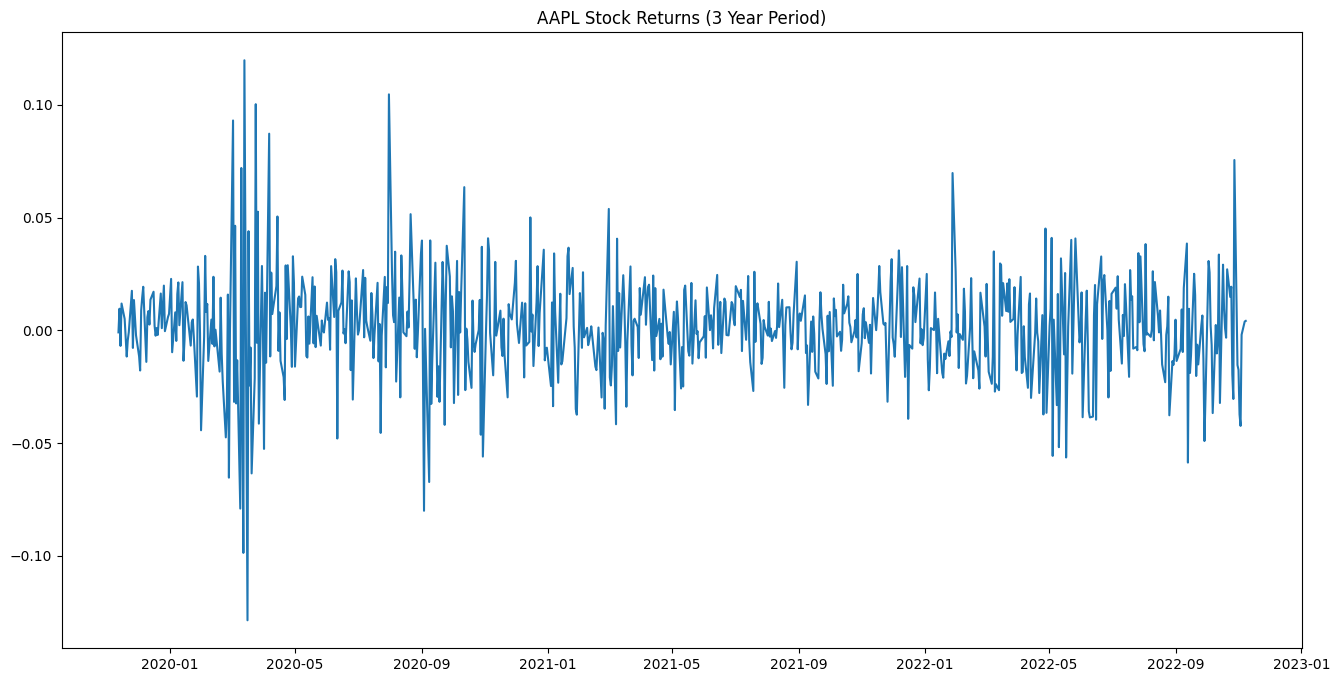

In [134]:
aapl_historical_returns = generateReturnsData(aapl_historical, "AAPL")


Epoch 1/30


2022-11-09 14:55:54.128798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 14:55:54.383415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 14:55:54.704025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 14:55:54.878243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 14:55:55.153324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


543/543 [==============================] - 21s 33ms/step - loss: 0.0129 - mean_squared_error: 0.0129
Epoch 2/30
543/543 [==============================] - 18s 33ms/step - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 3/30
543/543 [==============================] - 18s 33ms/step - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 4/30
543/543 [==============================] - 18s 33ms/step - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 5/30
543/543 [==============================] - 18s 32ms/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 6/30
543/543 [==============================] - 18s 33ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 7/30
543/543 [==============================] - 18s 33ms/step - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 8/30
543/543 [==============================] - 17s 32ms/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 9/30
543/543 [==============================] - 18s 34ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epo

2022-11-09 15:04:44.392156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 15:04:44.485860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 3s

2022-11-09 15:04:44.705295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 59ms/step


/var/folders/kz/rvchp60d4w32sw9xqslynkzm0000gn/T/ipykernel_25572/4133445988.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_returns['Predictions'] = predicted_closing_returns


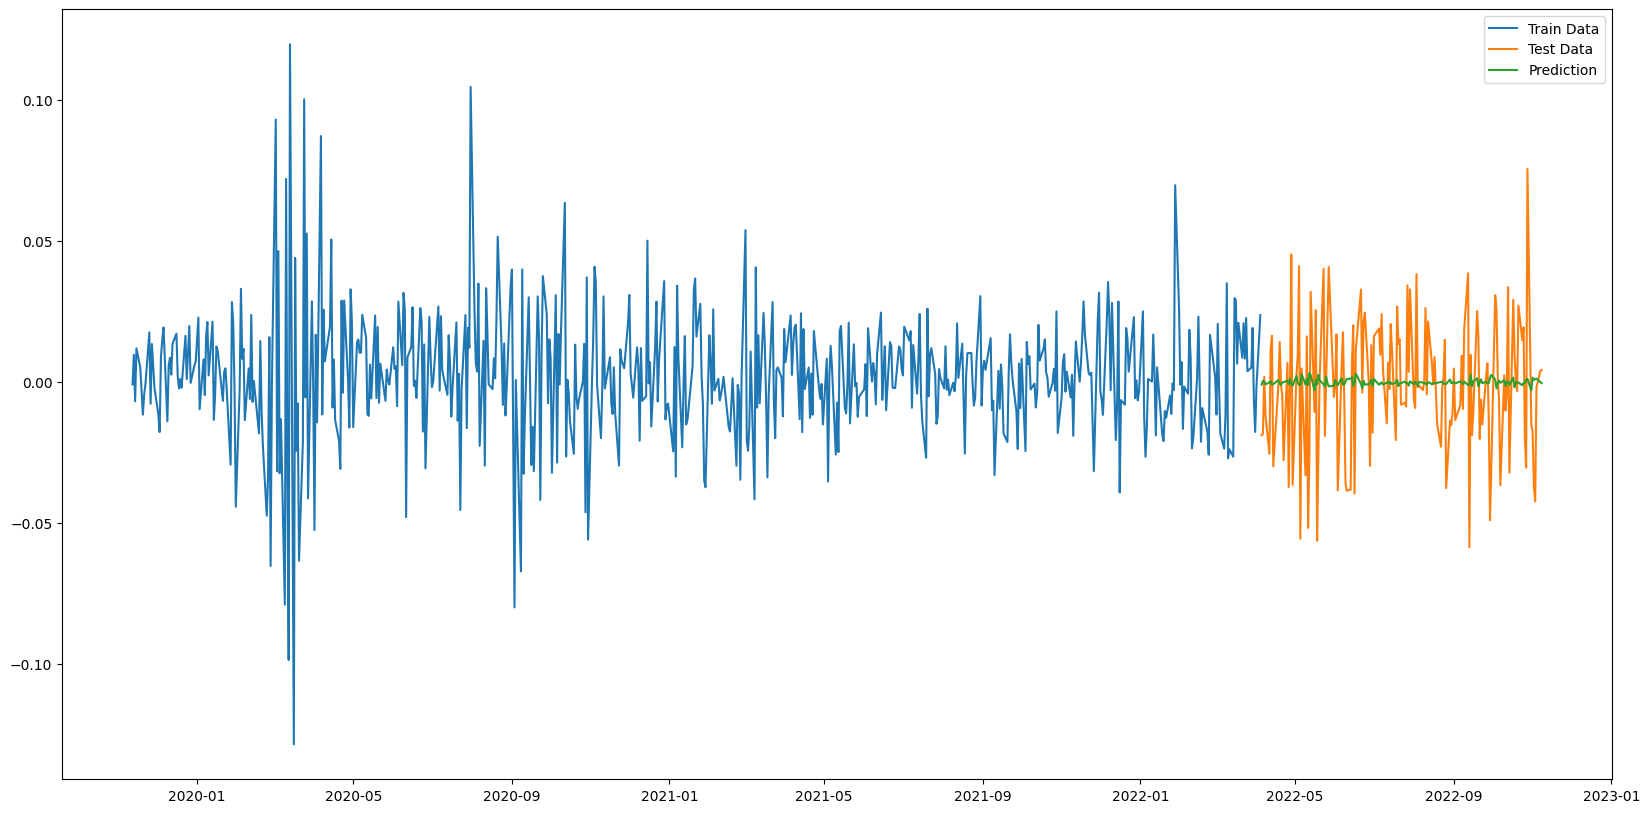

R-Squared Score:  -0.0013185832709838863
Mean Squared Error:  0.0005411140670673654
Mean Absolute Error:  0.018025779186530286


In [135]:
aapl_lstm_model_returns = predictReturns(aapl_historical_returns, 3, ['Returns', 'Close', 'Volume'])

Epoch 1/30


2022-11-09 00:11:22.939030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 00:11:23.147655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 00:11:23.304441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 00:11:23.449510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 00:11:23.659988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


77/77 [==============================] - 5s 35ms/step - loss: 0.0446 - mean_squared_error: 0.0446
Epoch 2/30
77/77 [==============================] - 3s 33ms/step - loss: 0.0445 - mean_squared_error: 0.0445
Epoch 3/30
77/77 [==============================] - 3s 34ms/step - loss: 0.0453 - mean_squared_error: 0.0453
Epoch 4/30
77/77 [==============================] - 3s 33ms/step - loss: 0.0394 - mean_squared_error: 0.0394
Epoch 5/30
77/77 [==============================] - 2s 32ms/step - loss: 0.0370 - mean_squared_error: 0.0370
Epoch 6/30
77/77 [==============================] - 2s 32ms/step - loss: 0.0392 - mean_squared_error: 0.0392
Epoch 7/30
77/77 [==============================] - 3s 34ms/step - loss: 0.0375 - mean_squared_error: 0.0375
Epoch 8/30
77/77 [==============================] - 2s 31ms/step - loss: 0.0359 - mean_squared_error: 0.0359
Epoch 9/30
77/77 [==============================] - 2s 31ms/step - loss: 0.0370 - mean_squared_error: 0.0370
Epoch 10/30
77/77 [===========

2022-11-09 00:12:41.550330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 00:12:41.628239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2022-11-09 00:12:41.762461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 179ms/step


/var/folders/kz/rvchp60d4w32sw9xqslynkzm0000gn/T/ipykernel_25572/4133445988.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_returns['Predictions'] = predicted_closing_returns


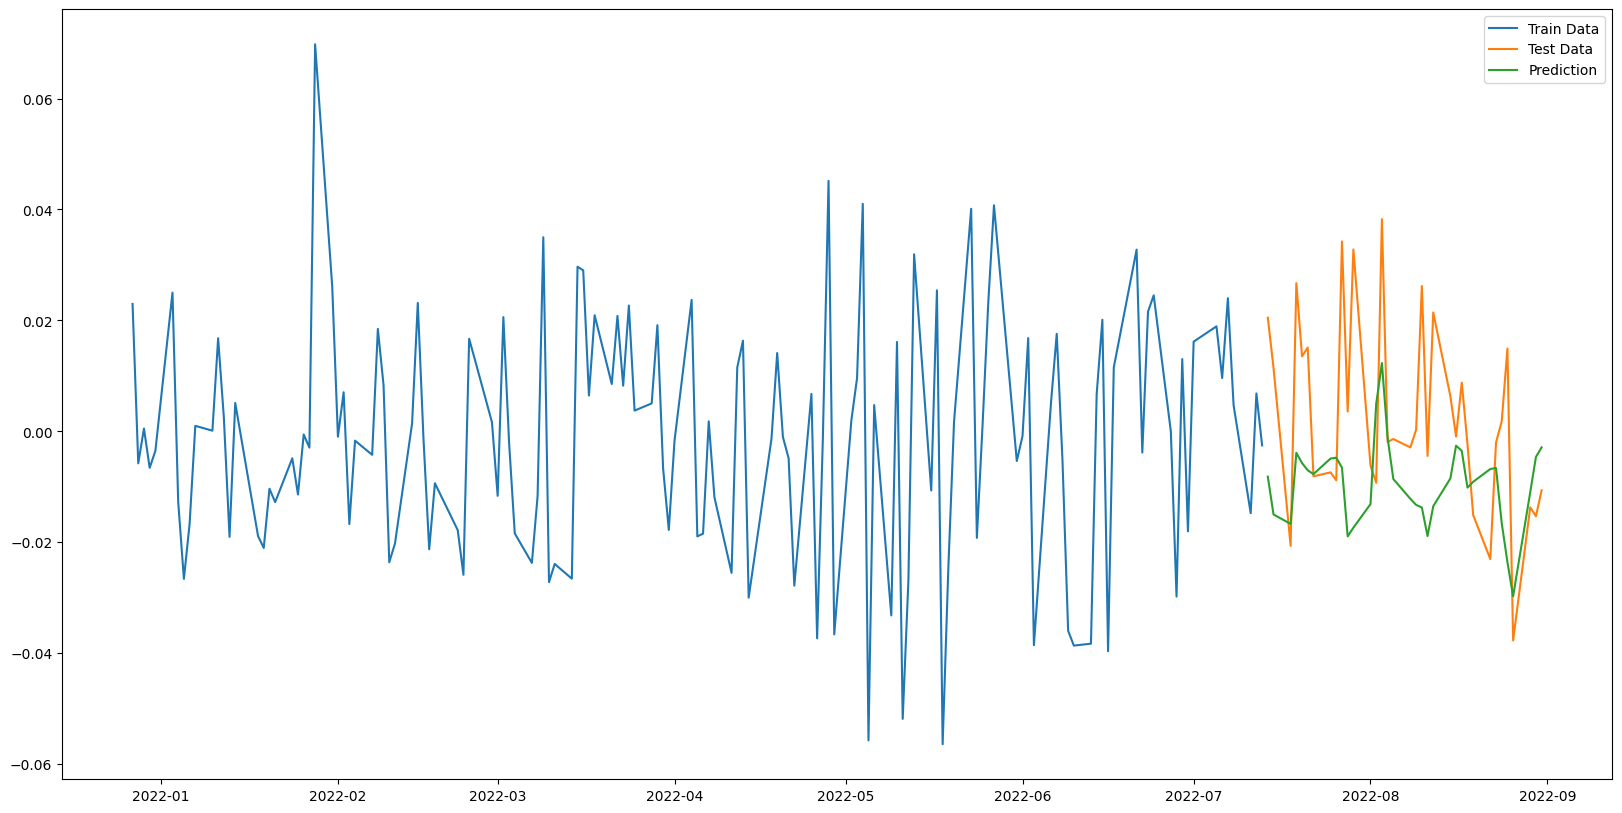

R-Squared Score:  -0.4844441908040802
Mean Squared Error:  0.0004322538591499525
Mean Absolute Error:  0.016231025552800874


In [117]:
aapl_historical_returns_w_sent = includeSentiment(aapl_historical_returns, 'AAPL', '../Data/3_Predictions/Unstructured_Data/rf_regressor/returns', '/finbert_pred_returns_rfr_test.csv')
aapl_lstm_model_returns_w_sent = predictReturns(aapl_historical_returns_w_sent, 4, ['Returns', 'Close', 'Volume', 'Sentiment'])


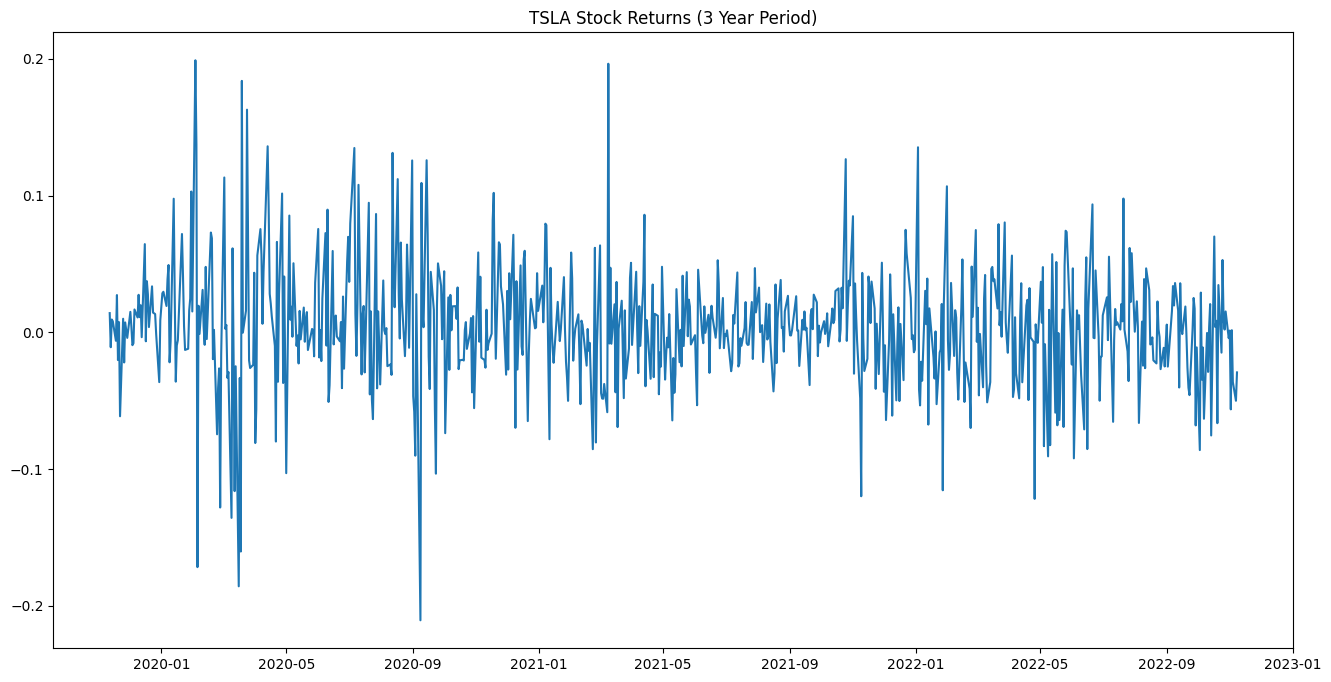

In [136]:
tsla_historical_returns = generateReturnsData(tsla_historical, "TSLA")

Epoch 1/30


2022-11-09 15:04:47.345278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 15:04:47.547215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 15:04:47.684996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 15:04:47.811552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 15:04:48.006183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


543/543 [==============================] - 20s 34ms/step - loss: 0.0202 - mean_squared_error: 0.0202
Epoch 2/30
543/543 [==============================] - 17s 32ms/step - loss: 0.0137 - mean_squared_error: 0.0137
Epoch 3/30
543/543 [==============================] - 18s 34ms/step - loss: 0.0135 - mean_squared_error: 0.0135
Epoch 4/30
543/543 [==============================] - 18s 33ms/step - loss: 0.0132 - mean_squared_error: 0.0132
Epoch 5/30
543/543 [==============================] - 17s 31ms/step - loss: 0.0127 - mean_squared_error: 0.0127
Epoch 6/30
543/543 [==============================] - 18s 33ms/step - loss: 0.0128 - mean_squared_error: 0.0128
Epoch 7/30
543/543 [==============================] - 17s 32ms/step - loss: 0.0130 - mean_squared_error: 0.0130
Epoch 8/30
543/543 [==============================] - 18s 33ms/step - loss: 0.0132 - mean_squared_error: 0.0132
Epoch 9/30
543/543 [==============================] - 17s 32ms/step - loss: 0.0128 - mean_squared_error: 0.0128
Epo

2022-11-09 15:13:32.053292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 15:13:32.143600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 3s

2022-11-09 15:13:32.306895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 62ms/step


/var/folders/kz/rvchp60d4w32sw9xqslynkzm0000gn/T/ipykernel_25572/4133445988.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_returns['Predictions'] = predicted_closing_returns


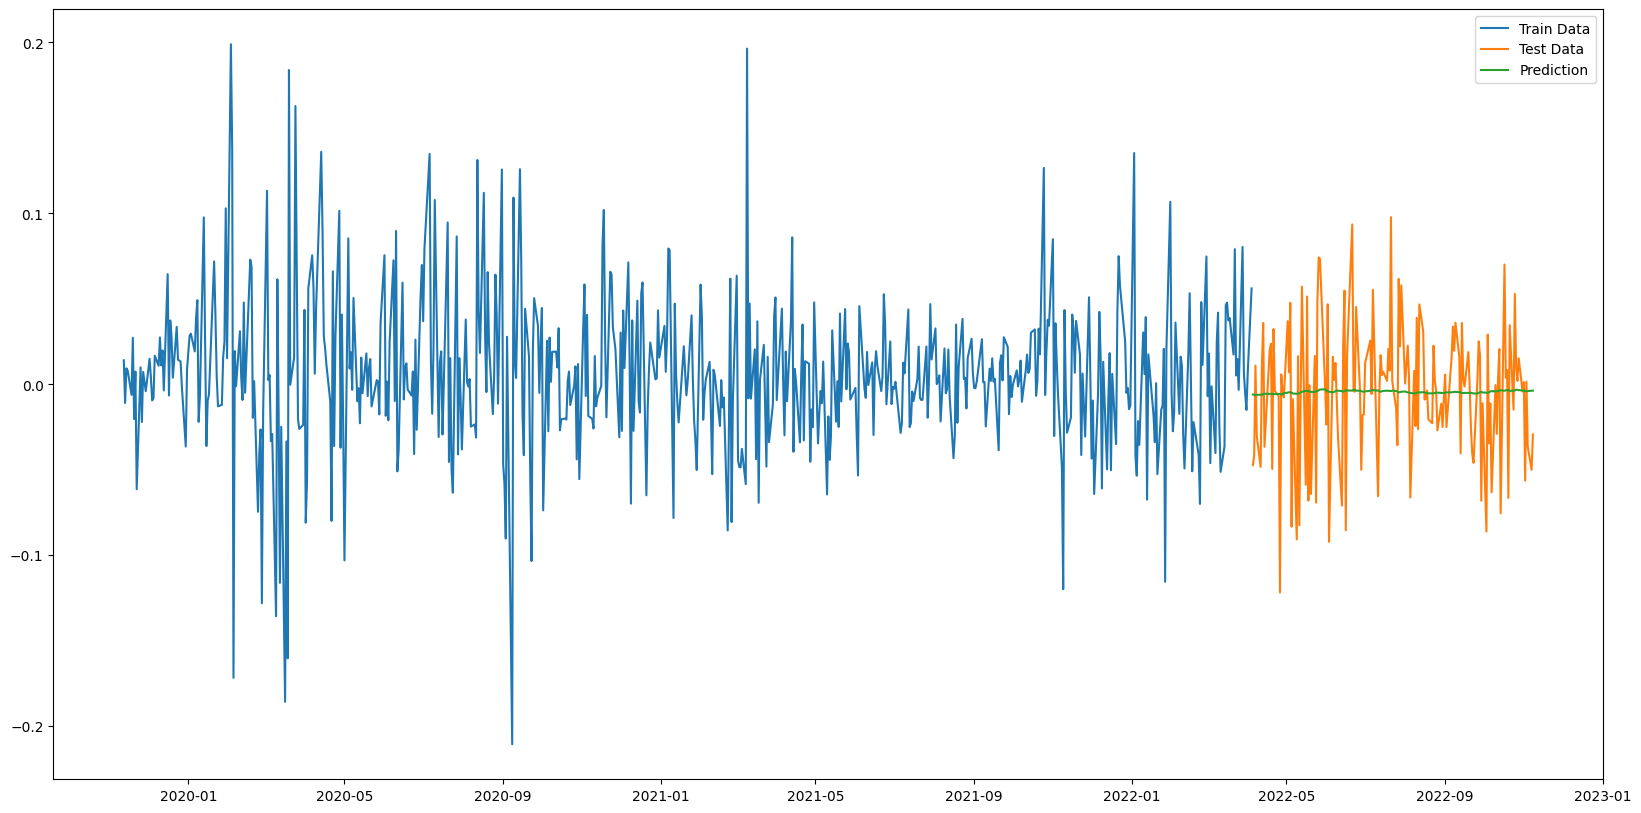

R-Squared Score:  0.004617610930782057
Mean Squared Error:  0.0015507433234821578
Mean Absolute Error:  0.03015554850040224


In [137]:
tsla_lstm_model_returns = predictReturns(tsla_historical_returns, 3, ['Returns', 'Close', 'Volume'])

Epoch 1/30


2022-11-09 00:08:57.417918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 00:08:57.610455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 00:08:57.754289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 00:08:57.890776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/77 [..............................] - ETA: 2:33 - loss: 0.6056 - mean_squared_error: 0.6056

2022-11-09 00:08:58.086208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


77/77 [==============================] - 5s 33ms/step - loss: 0.0516 - mean_squared_error: 0.0516
Epoch 2/30
77/77 [==============================] - 2s 32ms/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 3/30
77/77 [==============================] - 3s 33ms/step - loss: 0.0325 - mean_squared_error: 0.0325
Epoch 4/30
77/77 [==============================] - 3s 34ms/step - loss: 0.0354 - mean_squared_error: 0.0354
Epoch 5/30
77/77 [==============================] - 3s 33ms/step - loss: 0.0315 - mean_squared_error: 0.0315
Epoch 6/30
77/77 [==============================] - 3s 34ms/step - loss: 0.0341 - mean_squared_error: 0.0341
Epoch 7/30
77/77 [==============================] - 3s 34ms/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 8/30
77/77 [==============================] - 2s 32ms/step - loss: 0.0335 - mean_squared_error: 0.0335
Epoch 9/30
77/77 [==============================] - 2s 32ms/step - loss: 0.0308 - mean_squared_error: 0.0308
Epoch 10/30
77/77 [===========

2022-11-09 00:10:13.397946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 00:10:13.470052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 00:10:13.584663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 142ms/step


/var/folders/kz/rvchp60d4w32sw9xqslynkzm0000gn/T/ipykernel_25572/4133445988.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_returns['Predictions'] = predicted_closing_returns


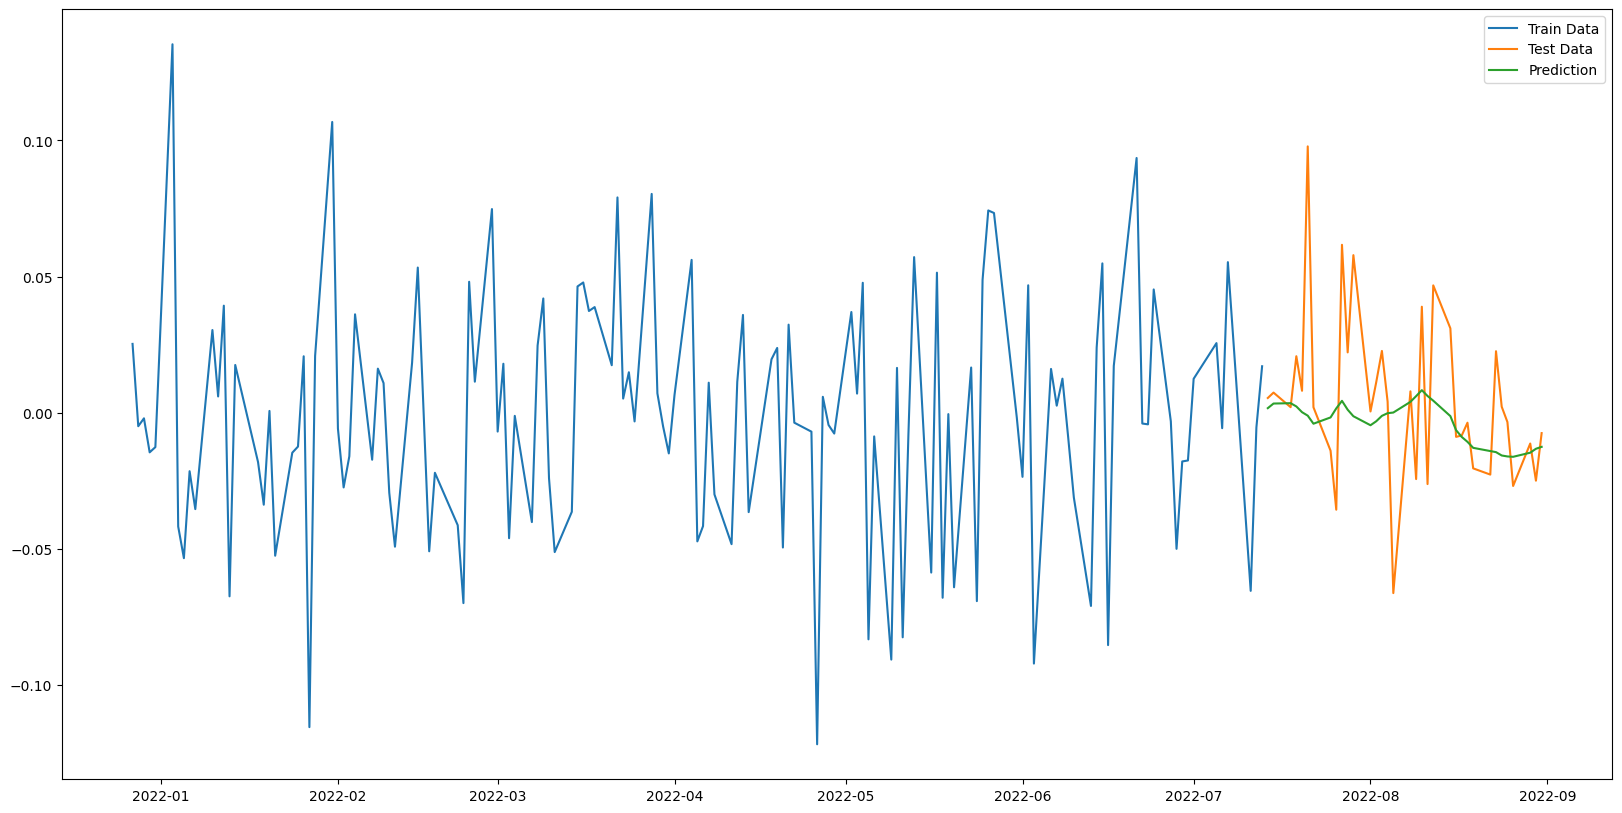

R-Squared Score:  0.010329886702886926
Mean Squared Error:  0.0009239104609008718
Mean Absolute Error:  0.02108610567124456


In [116]:
tsla_historical_returns_w_sent = includeSentiment(tsla_historical_returns, 'TSLA', '../Data/3_Predictions/Unstructured_Data/rf_regressor/returns', '/finbert_pred_returns_rfr_test.csv')
tsla_lstm_model_returns_w_sent = predictReturns(tsla_historical_returns_w_sent, 4, ['Returns', 'Close', 'Volume', 'Sentiment'])


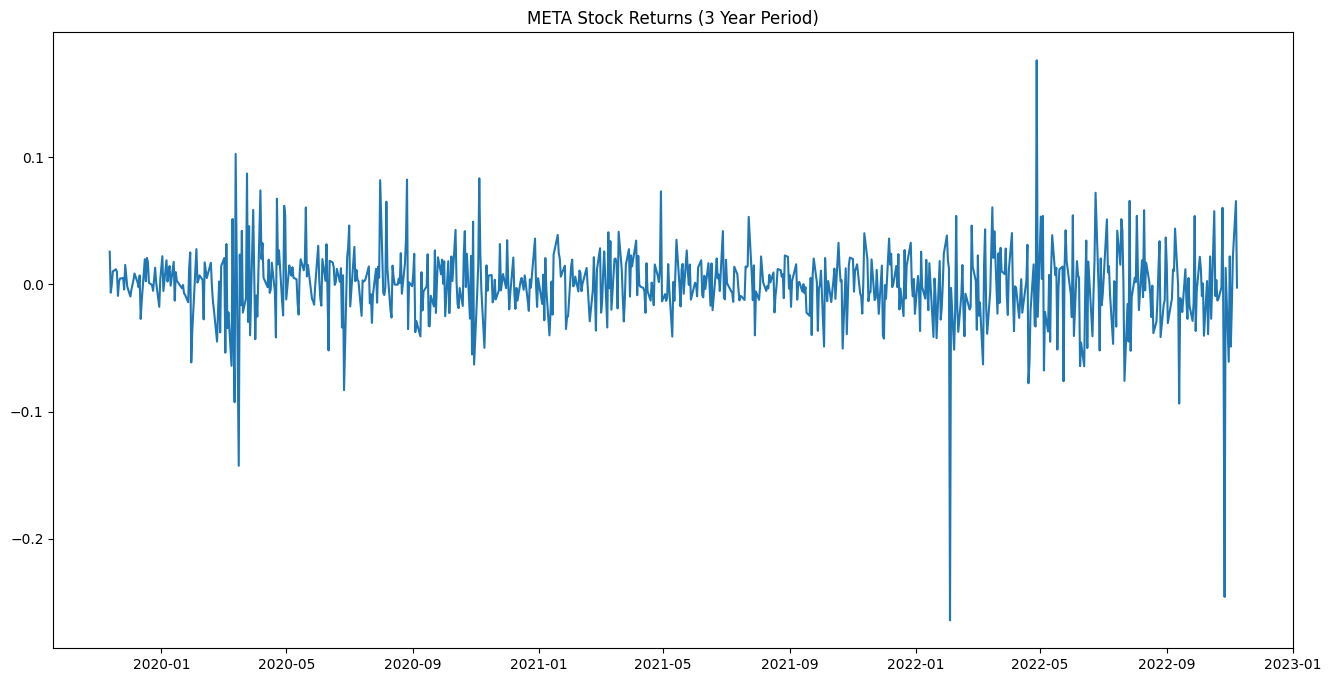

In [138]:
meta_historical_returns = generateReturnsData(meta_historical, "META")

Epoch 1/30


2022-11-09 15:13:38.208949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 15:13:38.468703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 15:13:38.628757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 15:13:38.830109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 15:13:39.105597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


543/543 [==============================] - 20s 33ms/step - loss: 0.0129 - mean_squared_error: 0.0129
Epoch 2/30
543/543 [==============================] - 18s 34ms/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 3/30
543/543 [==============================] - 19s 35ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 4/30
543/543 [==============================] - 19s 34ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 5/30
543/543 [==============================] - 18s 34ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 6/30
543/543 [==============================] - 19s 34ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 7/30
543/543 [==============================] - 19s 35ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 8/30
543/543 [==============================] - 18s 34ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 9/30
543/543 [==============================] - 18s 34ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epo

2022-11-09 15:22:57.884219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 15:22:57.987390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 15:22:58.212251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 84ms/step


/var/folders/kz/rvchp60d4w32sw9xqslynkzm0000gn/T/ipykernel_25572/4133445988.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_returns['Predictions'] = predicted_closing_returns


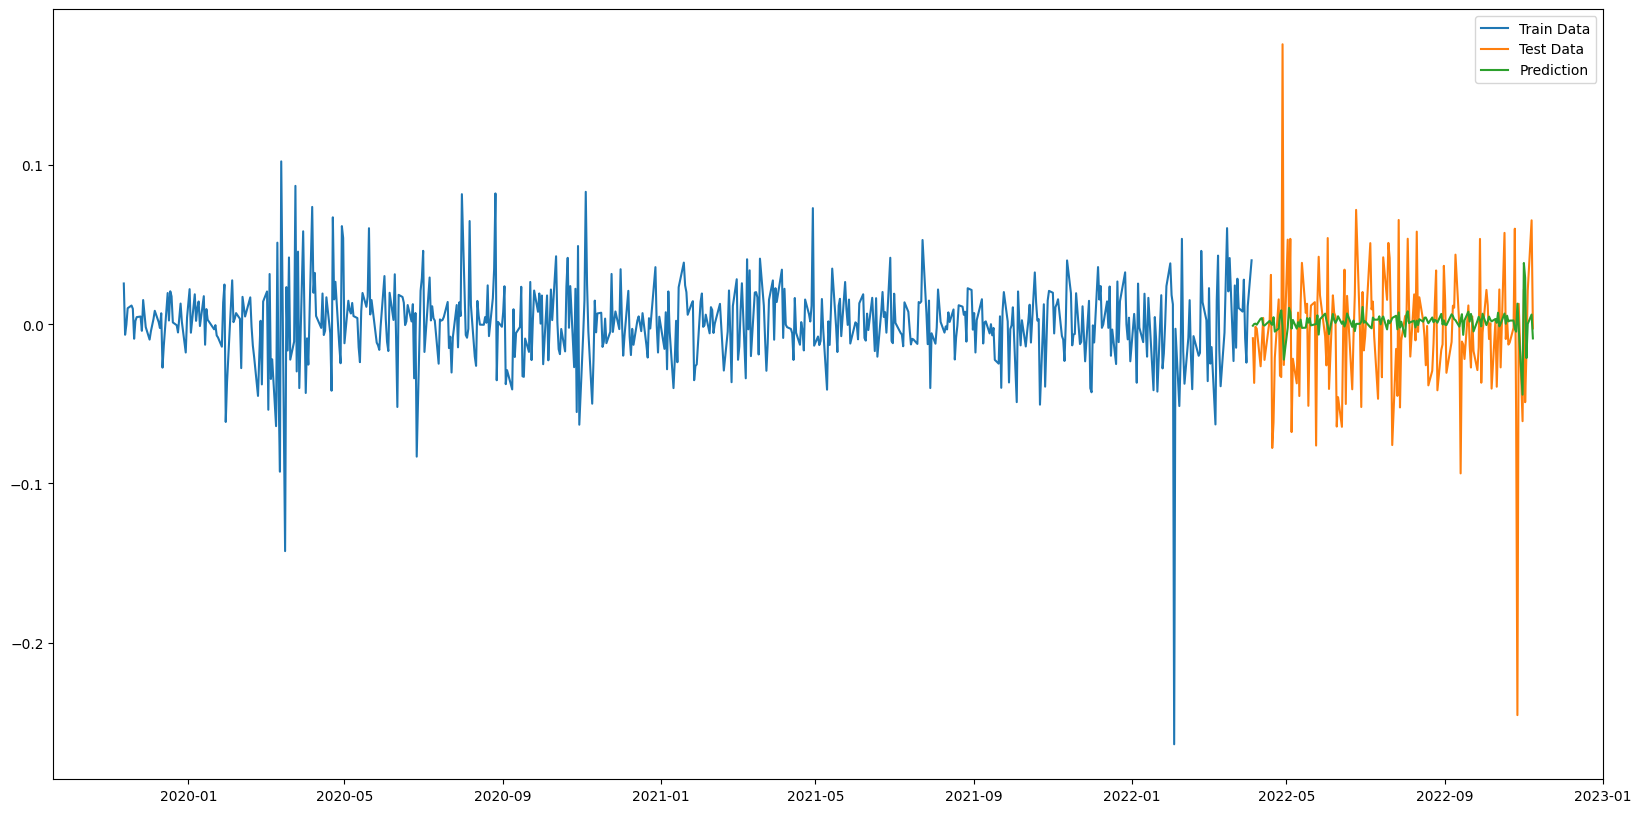

R-Squared Score:  -0.042544968136036365
Mean Squared Error:  0.0017466517281497006
Mean Absolute Error:  0.02831377562939757


In [139]:
meta_lstm_model_returns = predictReturns(meta_historical_returns, 3, ['Returns', 'Close', 'Volume'])

Epoch 1/30


2022-11-09 00:14:47.187787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 00:14:47.379818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 00:14:47.576411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 00:14:47.714144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 00:14:47.930815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


77/77 [==============================] - 5s 35ms/step - loss: 0.0277 - mean_squared_error: 0.0277
Epoch 2/30
77/77 [==============================] - 3s 34ms/step - loss: 0.0130 - mean_squared_error: 0.0130
Epoch 3/30
77/77 [==============================] - 3s 33ms/step - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 4/30
77/77 [==============================] - 2s 32ms/step - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 5/30
77/77 [==============================] - 3s 33ms/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 6/30
77/77 [==============================] - 3s 34ms/step - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 7/30
77/77 [==============================] - 3s 34ms/step - loss: 0.0124 - mean_squared_error: 0.0124
Epoch 8/30
77/77 [==============================] - 3s 33ms/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 9/30
77/77 [==============================] - 3s 33ms/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 10/30
77/77 [===========

2022-11-09 00:16:04.384377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-09 00:16:04.462016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2022-11-09 00:16:04.587211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 138ms/step


/var/folders/kz/rvchp60d4w32sw9xqslynkzm0000gn/T/ipykernel_25572/4133445988.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_returns['Predictions'] = predicted_closing_returns


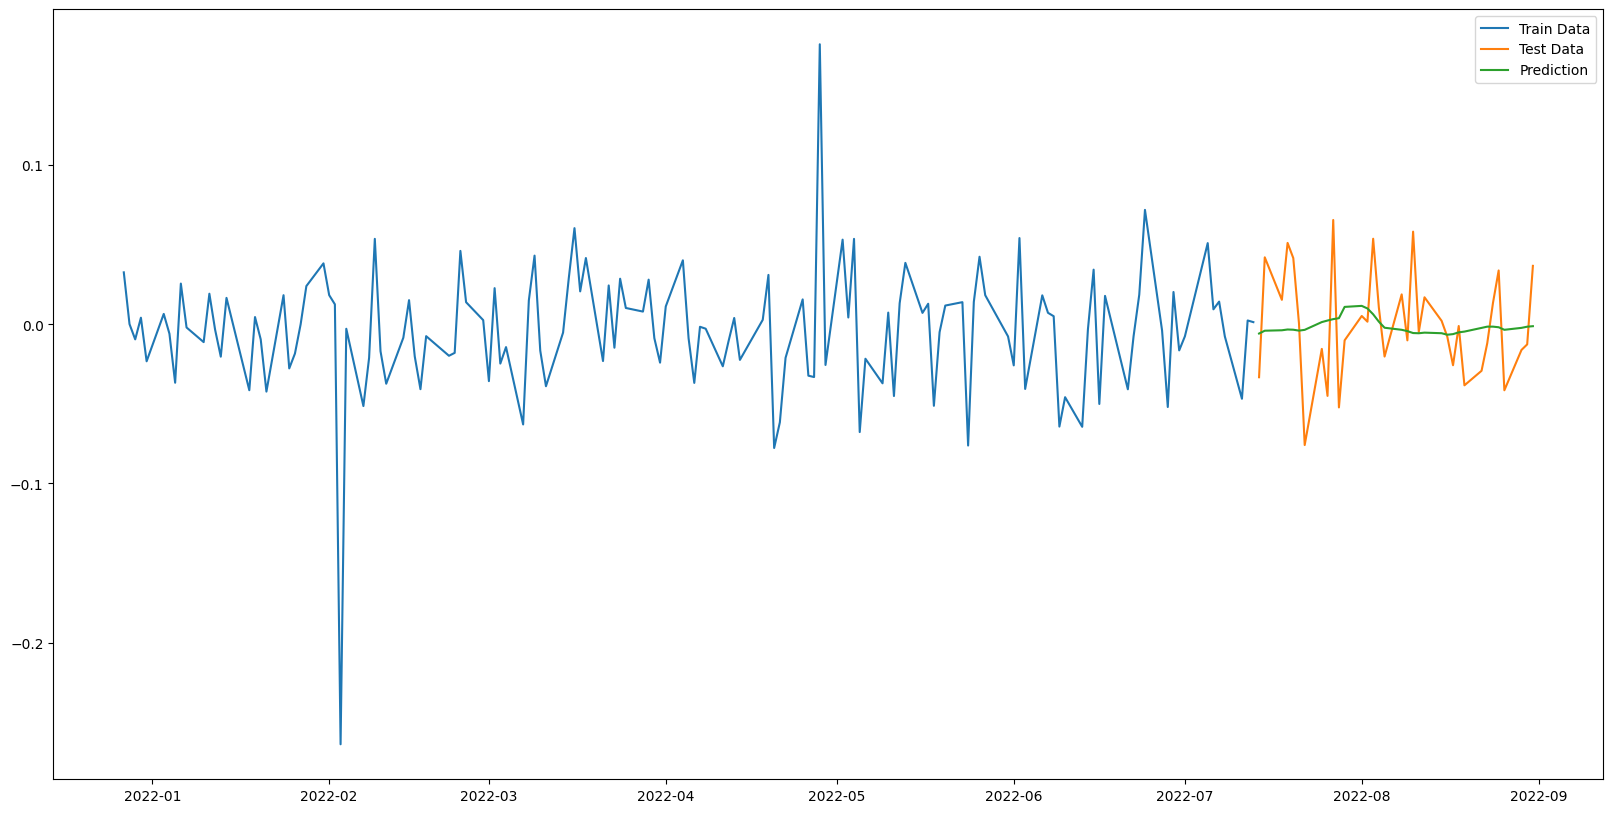

R-Squared Score:  -0.006904330247528456
Mean Squared Error:  0.0010989852784539151
Mean Absolute Error:  0.026617898670425716


In [122]:
meta_historical_returns_w_sent = includeSentiment(meta_historical_returns, 'META', '../Data/3_Predictions/Unstructured_Data/rf_regressor/returns', '/finbert_pred_returns_rfr_test.csv')
meta_lstm_model_returns_w_sent = predictReturns(meta_historical_returns_w_sent, 4, ['Returns', 'Close', 'Volume', 'Sentiment'])


## Reporting Results

### Predicting Close Price using Closing Price and Volume Traded
We are able to predict the closing price, we will provide valuable information to investors as they will know whether to long or short the stock.


In [97]:
# Input ticker - Using META as example
aapl_ticker = yf.Ticker("AAPL")

# Getting historical data of META
aapl_historical = aapl_ticker.history(period='3y')
aapl_historical

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-11-05 00:00:00-05:00,62.768081,63.046457,62.589830,62.787621,79897600,0.0000,0.0
2019-11-06 00:00:00-05:00,62.699704,62.875519,62.357845,62.814472,75864400,0.0000,0.0
2019-11-07 00:00:00-05:00,63.370441,63.764765,63.216141,63.539436,94940400,0.1925,0.0
2019-11-08 00:00:00-05:00,63.358212,63.786821,62.907561,63.713348,69986400,0.0000,0.0
2019-11-11 00:00:00-05:00,63.262681,64.283998,63.257785,64.217873,81821200,0.0000,0.0
...,...,...,...,...,...,...,...
2022-10-31 00:00:00-04:00,152.906350,153.984563,151.668398,153.086044,97943200,0.0000,0.0
2022-11-01 00:00:00-04:00,154.823169,155.192551,148.883026,150.400497,80379300,0.0000,0.0
2022-11-02 00:00:00-04:00,148.703316,151.917985,144.759861,144.789810,93604600,0.0000,0.0


In [99]:
# Saving 3 year historical of AAPL Stock
aapl_historical.to_csv('../Data/1_Scraped/Structured_Data/aapl_historical_3year.csv')

### AAPL Closing Price Plot

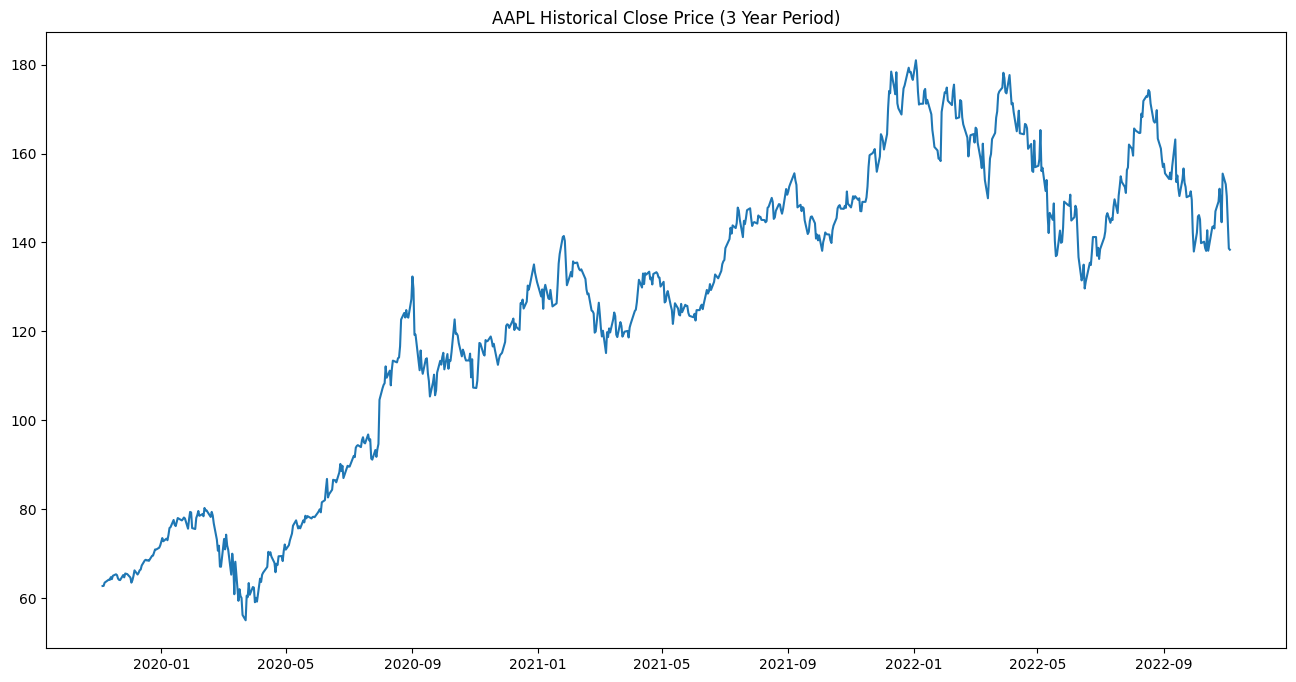

In [83]:
plt.figure(figsize=(16,8))
plt.plot(aapl_historical.index, aapl_historical["Close"], label='Close Price History')

plt.title('AAPL Historical Close Price (3 Year Period)')
plt.show()

### AAPL Volume Traded Plot

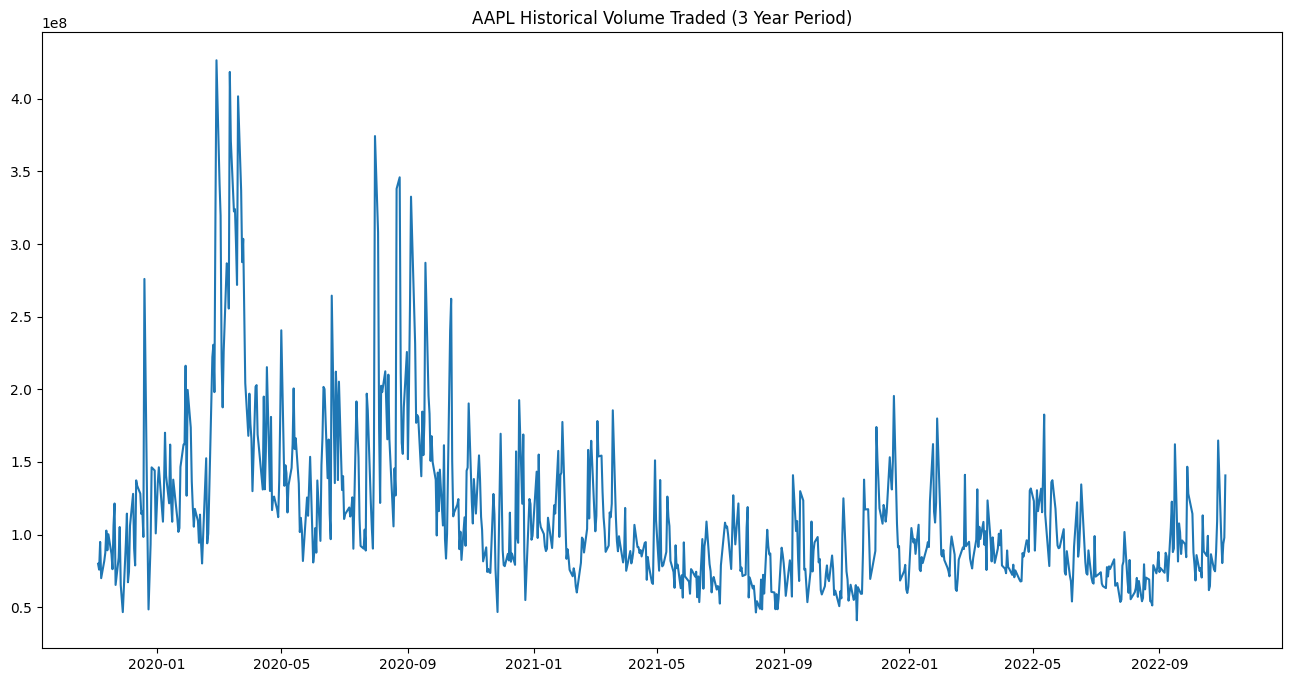

In [84]:
plt.figure(figsize=(16,8))
plt.plot(aapl_historical.index, aapl_historical["Volume"], label='Volume Traded History')

plt.title('AAPL Historical Volume Traded (3 Year Period)')
plt.show()

### Predicting Close Price using Closing Price and Volume Traded
We are able to predict the closing price, we will provide valuable information to investors as they will know whether to long or short the stock.


In [85]:
# Normalizing
aapl_historical_close = aapl_historical[['Close', 'Volume']]

# Spliting into Train and Test Data
train_test_split = int(len(aapl_historical_close) * 0.8)
aapl_historical_x_train = aapl_historical_close.iloc[:train_test_split]
aapl_historical_x_test = aapl_historical_close.iloc[train_test_split:]


# Scaling based on Training Data
scaler_price = MinMaxScaler(feature_range=(0,1))
scaled_price_data = scaler_price.fit_transform(aapl_historical_x_train) # scale only after split

x_train_data, y_train_data = [], []
num_input_points = 60

# Creating Training Data
for i in range(num_input_points, train_test_split):
    x_train_data.append(scaled_price_data[i-num_input_points:i])
    y_train_data.append(scaled_price_data[i, 0])

x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 2)) # shape is ((2019, 60), 1)

In [86]:
print(x_train_data.shape)
print(y_train_data.shape)

(545, 60, 2)
(545,)


### Building LSTM Model for Predicting Price

In [64]:
# Building the LSTM Model
lstm_model_price = Sequential()
lstm_model_price.add(LSTM(units=100, return_sequences=True, input_shape=(x_train_data.shape[1], 2)))
lstm_model_price.add(LSTM(units=100))
lstm_model_price.add(Dense(25))
lstm_model_price.add(Dense(1)) 
lstm_model_price.compile(loss='mean_squared_error',optimizer='adam', metrics=['mean_squared_error'])
lstm_model_price.fit(x_train_data,y_train_data,epochs=30,batch_size=1,verbose=1)

Epoch 1/30


2022-11-06 16:44:00.550456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-06 16:44:00.736358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-06 16:44:00.846237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-06 16:44:00.957490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/545 [..............................] - ETA: 15:36 - loss: 0.0256 - mean_squared_error: 0.0256

2022-11-06 16:44:01.133109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


545/545 [==============================] - 20s 33ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 2/30
545/545 [==============================] - 18s 33ms/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 3/30
545/545 [==============================] - 18s 33ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 4/30
545/545 [==============================] - 18s 33ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 5/30
545/545 [==============================] - 18s 32ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 6/30
545/545 [==============================] - 18s 32ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 7/30
545/545 [==============================] - 18s 33ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 8/30
545/545 [==============================] - 18s 33ms/step - loss: 9.3904e-04 - mean_squared_error: 9.3904e-04
Epoch 9/30
545/545 [==============================] - 18s 33ms/step - loss: 9.4810e-04 - mean_squared_error

In [68]:
# Saving trained LSTM Model for Predicting Price

lstm_model_price.save("LSTM_Model_Predicting_Closing_Price_epoch30_batchsize1.h5")

### Preparing Test Data for Stock Price

In [87]:
# Preparing Test data
test_input = aapl_historical_close.iloc[train_test_split - num_input_points:]
test_input = scaler_price.transform(test_input) 

X_test = []
# Creating Test Data
for i in range(num_input_points, test_input.shape[0]):
    X_test.append(test_input[i - num_input_points:i])
X_test = np.array(X_test)

predicted_closing_price = lstm_model_price.predict(X_test)
temp_column = np.zeros((predicted_closing_price.shape[0],1), dtype=int)
inverse_input = np.append(predicted_closing_price, temp_column, axis=1)

predicted_closing_price = scaler_price.inverse_transform(inverse_input)[:,0]


5/5 [==============================] - 0s 21ms/step


/var/folders/kz/rvchp60d4w32sw9xqslynkzm0000gn/T/ipykernel_1122/192583874.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_price['Predictions'] = predicted_closing_price


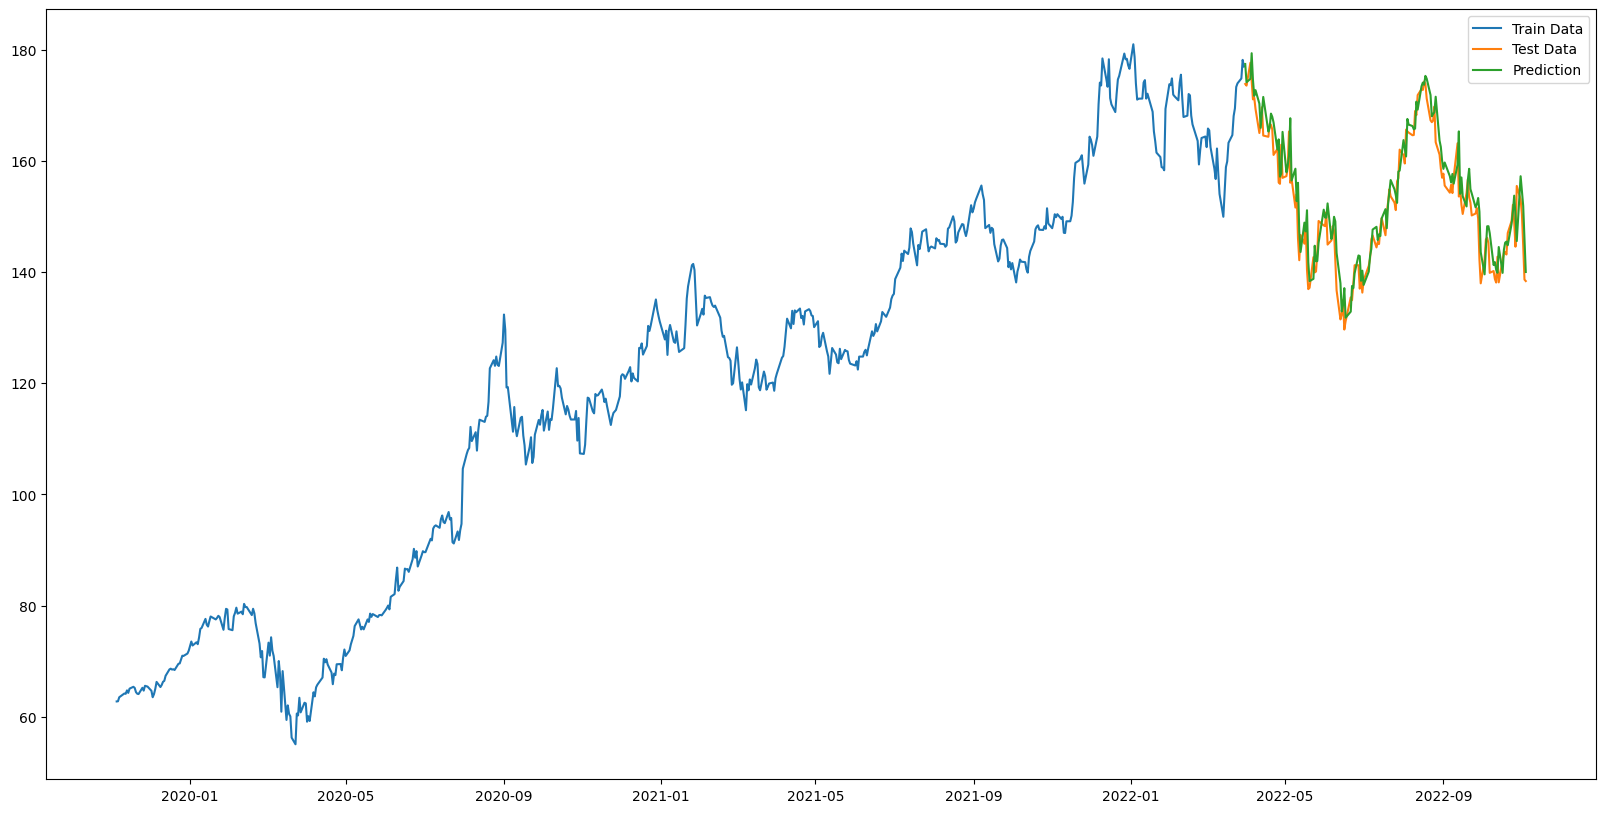

In [90]:
# Visualize the predicted stock costs with actual stock cost
train_data_price = aapl_historical_close[:train_test_split]
test_data_price = aapl_historical_close[train_test_split:]
test_data_price['Predictions'] = predicted_closing_price
plt.plot(train_data_price['Close'])
plt.plot(test_data_price['Close'])
plt.plot(test_data_price['Predictions'])
plt.legend(['Train Data', 'Test Data', 'Prediction'])

# plt.legend()
plt.show()


In [89]:
print("R-Squared Score: ", r2_score(test_data_price['Close'], test_data_price['Predictions']))
print("Mean Squared Error: ", mean_squared_error(test_data_price['Close'], test_data_price['Predictions']))
print("Mean Absolute Error: ", mean_absolute_error(test_data_price['Close'], test_data_price['Predictions']))

R-Squared Score:  0.8768100636051466
Mean Squared Error:  15.880330414066083
Mean Absolute Error:  3.087064894903841


/var/folders/kz/rvchp60d4w32sw9xqslynkzm0000gn/T/ipykernel_1122/3848354702.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_price['Predictions'] = predicted_closing_price
/var/folders/kz/rvchp60d4w32sw9xqslynkzm0000gn/T/ipykernel_1122/3848354702.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_price_correction['Predictions'] =  predicted_closing_price[1:]


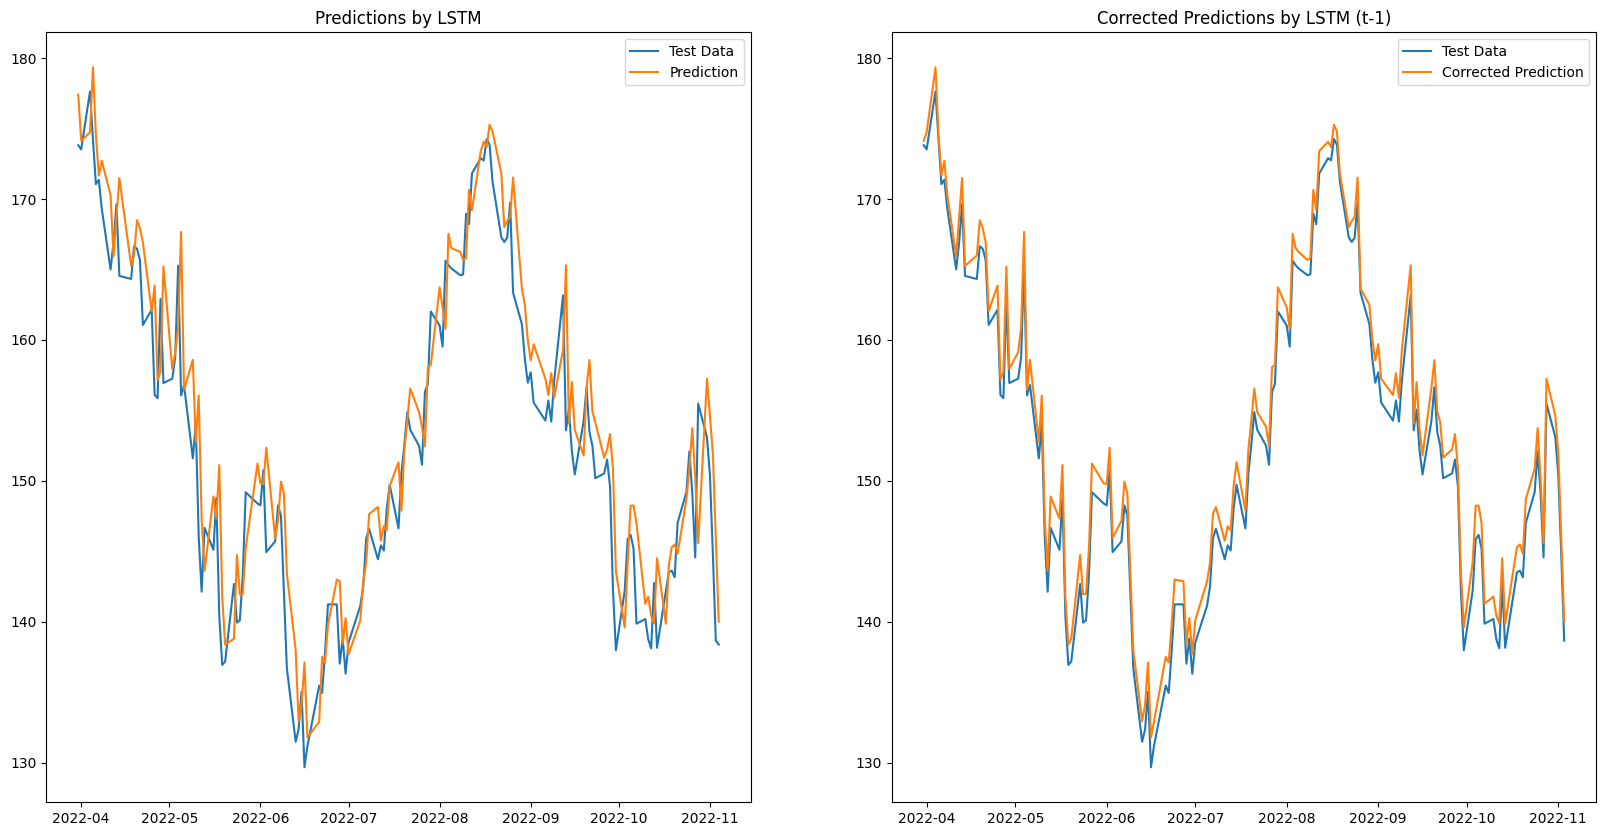

In [95]:
# Visualize the predicted stock costs with actual stock cost
fig, (ax1, ax2) = plt.subplots(1,2)

test_data_price = aapl_historical_close[train_test_split:]
test_data_price['Predictions'] = predicted_closing_price
ax1.set_title('Predictions by LSTM')
ax1.plot(test_data_price['Close'])
ax1.plot(test_data_price['Predictions'])
ax1.legend(['Test Data', 'Prediction'])

test_data_price_correction = test_data_price[:-1]
test_data_price_correction['Predictions'] =  predicted_closing_price[1:]
ax2.set_title('Corrected Predictions by LSTM (t-1)')
ax2.plot(test_data_price_correction['Close'])
ax2.plot(test_data_price_correction['Predictions'])
ax2.legend(['Test Data', 'Corrected Prediction'])


# plt.legend()
plt.show()


While the results of the model seem very good with r-squared value of 0.87681, we realised that the model might not be useful as it could just be predicting the closing price of day (t), as the closing price of the previous day, (t-1). 

Combined with our analysis of our trivial model where the model predicts the closing price of day (t) as the previous day (t-1), we realised that our decision to predict the closing price of day (t) is not very useful.

Hence, we refined our prediction to predict Stock Returns instead of Closing Stock Price. Predicting Stock Returns is more important than predicting Closing Stock price as the Stock Return will provide us the percentage increase of the Stock from the previous day and will let investors know whether the stock will increase or decrease in price. This indication will then help the investor, especially day traders, know whether to long or short the stock.

### Predicting Stock Returns using Closing Price and Volume Traded

We are able to predict the closing price, we will provide valuable information to investors as they will know whether to long or short the stock.


In [69]:
def getReturns(closingPrices):
  return pd.concat([pd.Series(np.nan), closingPrices.diff().reset_index(drop=True)[1:].reset_index(drop=True).div(closingPrices[:-1].reset_index(drop=True))]).reset_index(drop=True)

aapl_historical_returns = getReturns(aapl_historical['Close'])
aapl_historical_returns.index = aapl_historical.index
aapl_historical['Returns'] = aapl_historical_returns
aapl_historical = aapl_historical[1:]


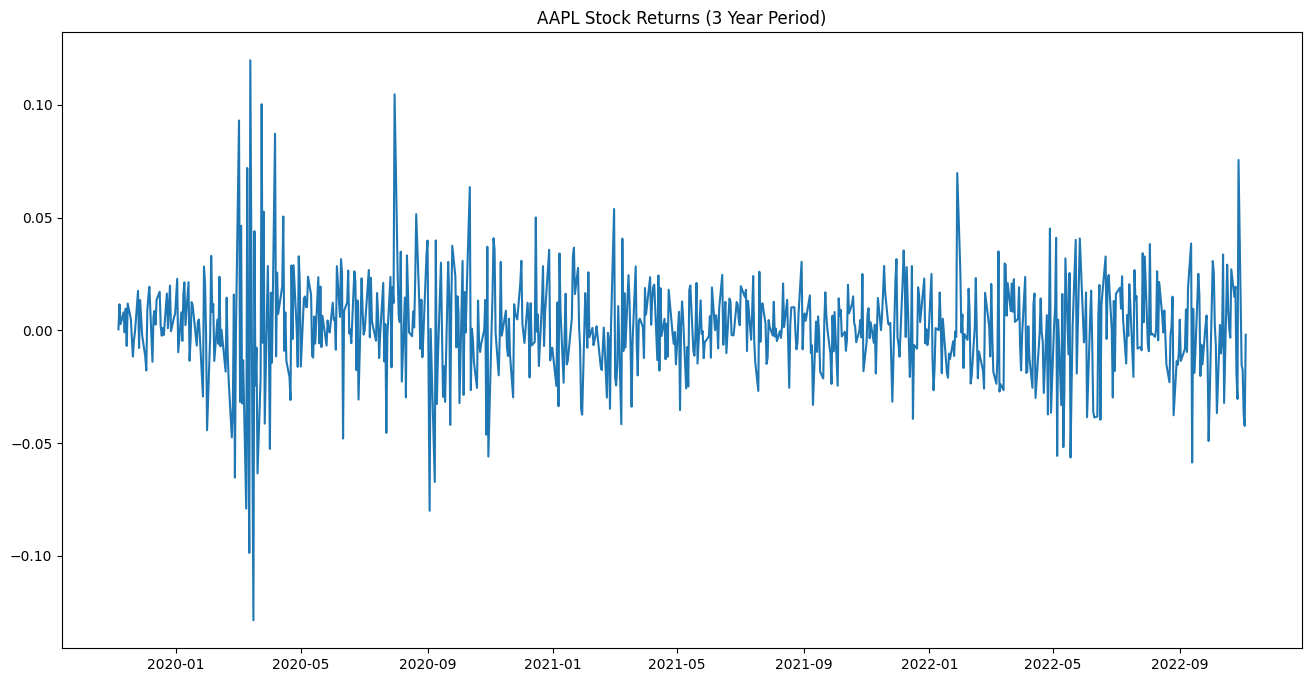

In [70]:
plt.figure(figsize=(16,8))
plt.plot(aapl_historical.index, aapl_historical["Returns"], label='AAPL Stock Returns 3 Year')
plt.title('AAPL Stock Returns (3 Year Period)')
plt.show()

### Choosing Returns over Close Price
Predicting Close Price is a trivial model as the model can just predict the exact same Closing Price of the previous day. i.e. model(t) = model(t-1) and there will be a high r-squared value.

Hence, we choose to predict returns instead of close price.

In [71]:
# Normalizing
# aapl_historical_returns = aapl_historical[['Returns']]
aapl_historical_returns = aapl_historical[['Returns', 'Close', 'Volume']] # Volume

# Spliting into Train and Test Data
train_test_split = int(len(aapl_historical_returns) * 0.8)
aapl_historical_train = aapl_historical_returns.iloc[:train_test_split]
aapl_historical_test = aapl_historical_returns.iloc[train_test_split:]

# Scaling based on Training Data
scaler_returns = MinMaxScaler(feature_range=(0,1))
scaled_returns_data = scaler_returns.fit_transform(aapl_historical_train) # scale only after split

x_train_data, y_train_data = [], []
num_input_points = 60

# Creating Training Data
for i in range(num_input_points, train_test_split):
    x_train_data.append(scaled_returns_data[i-num_input_points:i])
    y_train_data.append(scaled_returns_data[i, 0])

x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 3)) 

In [72]:
print(x_train_data.shape)
print(y_train_data.shape)

(544, 60, 3)
(544,)


In [73]:
# Continuous
# Building the LSTM Model
lstm_model_returns = Sequential()
lstm_model_returns.add(LSTM(units=100, return_sequences=True, input_shape=(x_train_data.shape[1], 3)))
lstm_model_returns.add(LSTM(units=100))
lstm_model_returns.add(Dense(25))
lstm_model_returns.add(Dense(1))
lstm_model_returns.compile(loss='mean_squared_error',optimizer='adam', metrics=['mean_squared_error'])
lstm_model_returns.fit(x_train_data,y_train_data,epochs=30,batch_size=1,verbose=1)

Epoch 1/30


2022-11-06 16:54:23.579315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-06 16:54:23.763417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-06 16:54:23.870505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-06 16:54:23.996039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/544 [..............................] - ETA: 15:39 - loss: 0.2771 - mean_squared_error: 0.2771

2022-11-06 16:54:24.171470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


544/544 [==============================] - 19s 32ms/step - loss: 0.0143 - mean_squared_error: 0.0143
Epoch 2/30
544/544 [==============================] - 18s 32ms/step - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 3/30
544/544 [==============================] - 18s 33ms/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 4/30
544/544 [==============================] - 18s 32ms/step - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 5/30
544/544 [==============================] - 18s 32ms/step - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 6/30
544/544 [==============================] - 19s 34ms/step - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 7/30
544/544 [==============================] - 18s 32ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 8/30
544/544 [==============================] - 17s 32ms/step - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 9/30
544/544 [==============================] - 17s 32ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epo

In [78]:
# Saving trained LSTM Model for Predicting Price

lstm_model_returns.save("LSTM_Model_Predicting_Stock_Returns_epoch30_batchsize1.h5")

### Preparing Test Data for Stock Returns

In [75]:
# Preparing Test data
test_input = aapl_historical_returns[train_test_split - num_input_points:]
test_input = scaler_returns.transform(test_input)

X_test = []
for i in range(num_input_points, test_input.shape[0]):
    X_test.append(test_input[i - num_input_points:i])
X_test = np.array(X_test)

predicted_closing_returns = lstm_model_returns.predict(X_test)
temp_column = np.zeros((predicted_closing_price.shape[0],2), dtype=int)
inverse_input = np.append(predicted_closing_returns, temp_column, axis=1)
predicted_closing_returns = scaler_returns.inverse_transform(inverse_input)[:,0]


5/5 [==============================] - 0s 23ms/step


/var/folders/kz/rvchp60d4w32sw9xqslynkzm0000gn/T/ipykernel_1122/530035970.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_returns['Predictions'] = predicted_closing_returns


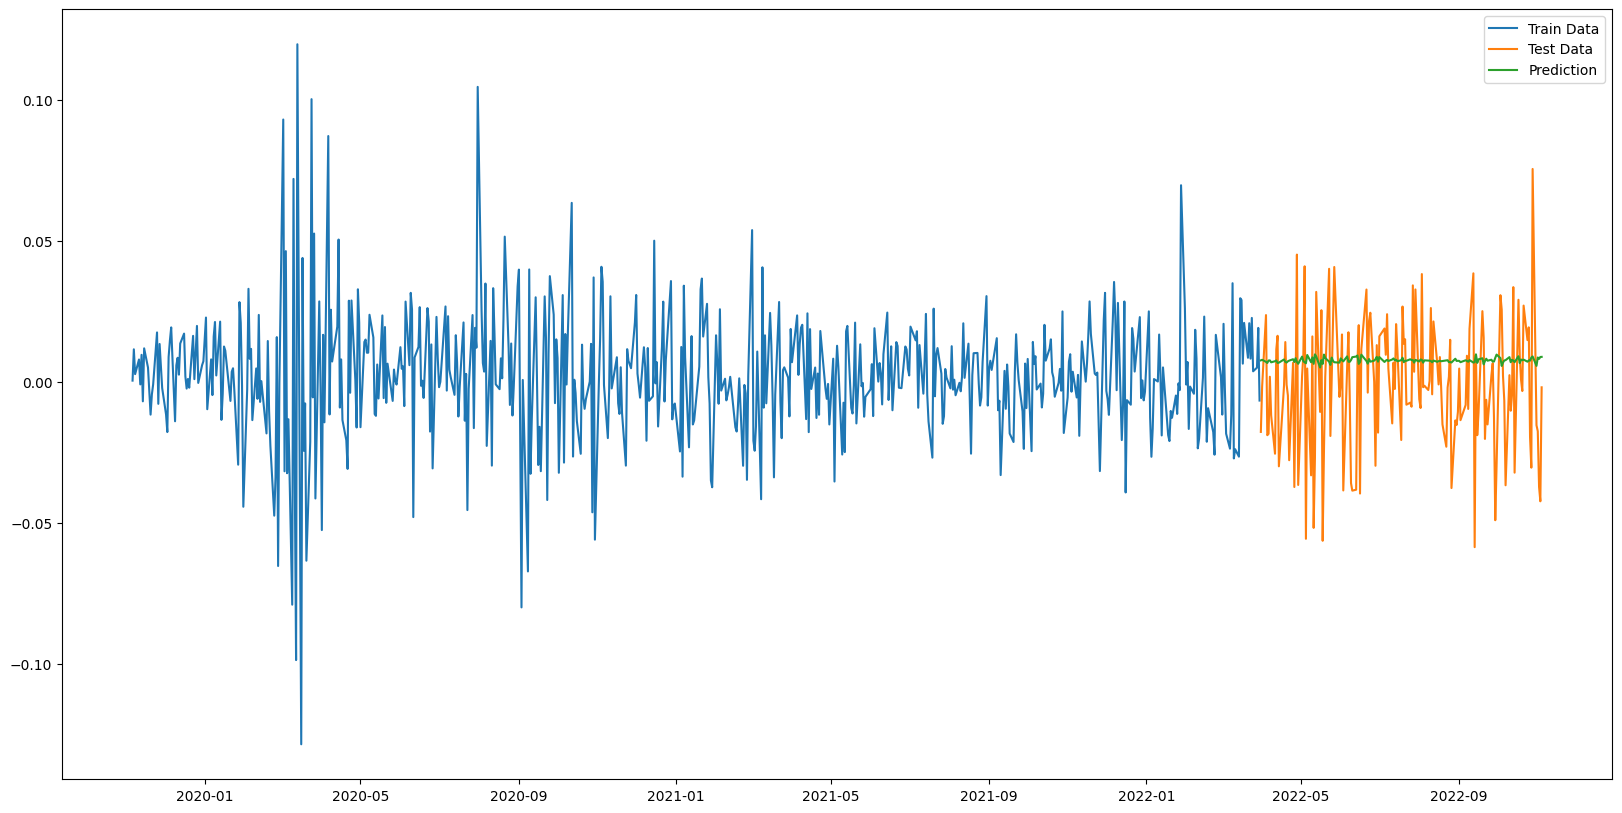

In [76]:
# Visualize the predicted stock costs with actual stock cost
train_data_returns = aapl_historical_returns[:train_test_split]
test_data_returns = aapl_historical_returns[train_test_split:]
test_data_returns['Predictions'] = predicted_closing_returns
plt.plot(train_data_returns['Returns'])
plt.plot(test_data_returns['Returns'])
plt.plot(test_data_returns['Predictions'])
plt.legend(['Train Data', 'Test Data', 'Prediction'])

# plt.legend()
plt.show()


In [77]:
print("R-Squared Score: ", r2_score(test_data_returns['Returns'], test_data_returns['Predictions']))
print("Mean Squared Error: ", mean_squared_error(test_data_returns['Returns'], test_data_returns['Predictions']))
print("Mean Absolute Error: ", mean_absolute_error(test_data_returns['Returns'], test_data_returns['Predictions']))

R-Squared Score:  -0.14346858442738664
Mean Squared Error:  0.0006201789400772203
Mean Absolute Error:  0.01968498302024791
